In [3]:
from FOC import FOC
import os
import pandas as pd
from bs4 import BeautifulSoup
import yfinance as yf
from datetime import datetime, timedelta
import pickle
from pathlib import Path
os.system("rsync -aE --delete '../../shared_infrastructure' './'")
from shared_infrastructure.WilliamXXu_numerical import *
from shared_infrastructure.WilliamXXu_core import *
from datetime import date,datetime,timedelta
%run volatility_functions.ipynb
%run correlation_functions.ipynb

In [4]:
latest_pval=lambda s: larger_proportion(s.dropna(),s[-1])

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import pdist

def clustered_heatmap(df, 
                     method='ward', 
                     metric='euclidean',
                     cluster_rows=True, 
                     cluster_cols=True,
                     figsize=(12, 10),
                     cmap='viridis',
                     annot=False,
                     fmt='.2f',
                     use_seaborn_clustermap=True,
                     **kwargs):
    """
    Create a heatmap with hierarchical clustering of rows and/or columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe to cluster and plot
    method : str, default 'ward'
        Linkage method for clustering ('ward', 'complete', 'average', 'single')
    metric : str, default 'euclidean'
        Distance metric ('euclidean', 'correlation', 'cosine', etc.)
    cluster_rows : bool, default True
        Whether to cluster rows
    cluster_cols : bool, default True
        Whether to cluster columns
    figsize : tuple, default (12, 10)
        Figure size (width, height)
    cmap : str, default 'viridis'
        Colormap for heatmap
    annot : bool, default False
        Whether to annotate cells with values
    fmt : str, default '.2f'
        String formatting for annotations
    use_seaborn_clustermap : bool, default True
        Whether to use seaborn's clustermap (recommended) or custom implementation
    **kwargs : additional arguments
        Additional arguments passed to seaborn plotting functions
    
    Returns:
    --------
    If use_seaborn_clustermap=True:
        ClusterGrid object from seaborn
    If use_seaborn_clustermap=False:
        tuple: (fig, clustered_df)
    """
    
    # Handle missing values
    df_clean = df.fillna(0)
    
    if use_seaborn_clustermap:
        # Use seaborn's clustermap - this ensures perfect alignment
        g = sns.clustermap(df_clean,
                          method=method,
                          metric=metric,
                          row_cluster=cluster_rows,
                          col_cluster=cluster_cols,
                          figsize=figsize,
                          cmap=cmap,
                          annot=annot,
                          fmt=fmt,
                          **kwargs)
        
        # Access the clustered dataframe
        clustered_df = df_clean.iloc[g.dendrogram_row.reordered_ind, 
                                    g.dendrogram_col.reordered_ind]
        
        return g, clustered_df
    
    else:
        # Custom implementation with proper alignment
        return _custom_clustered_heatmap(df_clean, method, metric, cluster_rows, 
                                       cluster_cols, figsize, cmap, annot, fmt, **kwargs)


def _custom_clustered_heatmap(df, method, metric, cluster_rows, cluster_cols, 
                             figsize, cmap, annot, fmt, **kwargs):
    """
    Custom implementation of clustered heatmap with proper dendrogram alignment.
    """
    
    # Initialize variables
    row_linkage = None
    col_linkage = None
    row_order = list(range(len(df)))
    col_order = list(range(len(df.columns)))
    
    # Perform hierarchical clustering for rows
    if cluster_rows and len(df) > 1:
        row_distances = pdist(df.values, metric=metric)
        row_linkage = linkage(row_distances, method=method)
        row_order = leaves_list(row_linkage)
    
    # Perform hierarchical clustering for columns
    if cluster_cols and len(df.columns) > 1:
        col_distances = pdist(df.T.values, metric=metric)
        col_linkage = linkage(col_distances, method=method)
        col_order = leaves_list(col_linkage)
    
    # Reorder dataframe
    clustered_df = df.iloc[row_order, col_order]
    
    # Create the plot
    fig = plt.figure(figsize=figsize)
    
    # Calculate subplot positions
    show_row_dendr = cluster_rows and len(df) > 1 and row_linkage is not None
    show_col_dendr = cluster_cols and len(df.columns) > 1 and col_linkage is not None
    
    dendr_height = 0.15 if show_col_dendr else 0
    dendr_width = 0.15 if show_row_dendr else 0
    
    # Main heatmap position
    heatmap_left = dendr_width + 0.05
    heatmap_bottom = 0.1
    heatmap_width = 0.85 - dendr_width
    heatmap_height = 0.85 - dendr_height
    
    # Create main heatmap
    ax_heatmap = fig.add_axes([heatmap_left, heatmap_bottom, 
                             heatmap_width, heatmap_height])
    
    # Plot heatmap with clustered data
    im = ax_heatmap.imshow(clustered_df.values, cmap=cmap, aspect='auto')
    
    # Set ticks and labels
    ax_heatmap.set_xticks(range(len(clustered_df.columns)))
    ax_heatmap.set_yticks(range(len(clustered_df.index)))
    ax_heatmap.set_xticklabels(clustered_df.columns, rotation=45, ha='right')
    ax_heatmap.set_yticklabels(clustered_df.index)
    
    # Add annotations if requested
    if annot:
        for i in range(len(clustered_df.index)):
            for j in range(len(clustered_df.columns)):
                text = ax_heatmap.text(j, i, format(clustered_df.iloc[i, j], fmt),
                                     ha="center", va="center", color="white" if clustered_df.iloc[i, j] < clustered_df.values.mean() else "black")
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.92, heatmap_bottom, 0.03, heatmap_height])
    fig.colorbar(im, cax=cbar_ax)
    
    # Add column dendrogram
    if show_col_dendr:
        ax_col_dendr = fig.add_axes([heatmap_left, heatmap_bottom + heatmap_height + 0.02, 
                                   heatmap_width, dendr_height])
        
        # Create temporary dendrogram to get the correct ordering
        temp_dendr = dendrogram(col_linkage, no_plot=True)
        
        # Plot dendrogram with correct leaf order
        dendr_plot = dendrogram(col_linkage, ax=ax_col_dendr, 
                               orientation='top', 
                               color_threshold=0,
                               above_threshold_color='black')
        
        ax_col_dendr.set_xticks([])
        ax_col_dendr.set_yticks([])
        for spine in ax_col_dendr.spines.values():
            spine.set_visible(False)
    
    # Add row dendrogram
    if show_row_dendr:
        ax_row_dendr = fig.add_axes([0.05, heatmap_bottom, 
                                   dendr_width, heatmap_height])
        
        # Create temporary dendrogram to get the correct ordering
        temp_dendr = dendrogram(row_linkage, no_plot=True)
        
        # Plot dendrogram with correct leaf order
        dendr_plot = dendrogram(row_linkage, ax=ax_row_dendr, 
                               orientation='left',
                               color_threshold=0,
                               above_threshold_color='black')
        
        ax_row_dendr.set_xticks([])
        ax_row_dendr.set_yticks([])
        for spine in ax_row_dendr.spines.values():
            spine.set_visible(False)
    
    plt.tight_layout()
    return fig, clustered_df


# Simplified function using seaborn (recommended)
def quick_clustered_heatmap(df, **kwargs):
    """
    Quick and easy clustered heatmap using seaborn's clustermap.
    This is the recommended approach for most use cases.
    """
    defaults = {
        'method': 'ward',
        'metric': 'euclidean', 
        'figsize': (12, 10),
        'cmap': 'viridis',
        'annot': False
    }
    defaults.update(kwargs)
    
    g = sns.clustermap(df.fillna(0), **defaults)
    return g


# # Example usage function
# def example_usage():
#     """
#     Example of how to use the clustered_heatmap function
#     """
#     # Create sample data
#     np.random.seed(42)
#     data = np.random.randn(20, 15)
    
#     # Add some structure to make clustering meaningful
#     data[:10, :7] += 2  # Upper-left quadrant
#     data[10:, 7:] += 2  # Lower-right quadrant
    
#     # Create DataFrame
#     df = pd.DataFrame(data, 
#                      index=[f'Gene_{i}' for i in range(20)],
#                      columns=[f'Sample_{i}' for i in range(15)])
    
#     # Method 1: Using seaborn clustermap (recommended)
#     print("Creating clustered heatmap using seaborn...")
#     g = quick_clustered_heatmap(df, 
#                                cmap='RdBu_r',
#                                figsize=(12, 8))
#     plt.suptitle('Seaborn Clustered Heatmap', y=0.95)
#     plt.show()
    
#     # Method 2: Using custom function
#     print("Creating clustered heatmap using custom function...")
#     result = clustered_heatmap(df,
#                               method='ward',
#                               metric='euclidean',
#                               figsize=(14, 10),
#                               cmap='RdBu_r',
#                               annot=False,
#                               use_seaborn_clustermap=True)
    
#     if len(result) == 2:
#         g, clustered_df = result
#         plt.suptitle('Custom Clustered Heatmap', y=0.95)
#         plt.show()
#         return clustered_df
#     else:
#         g = result
#         return g

# # Uncomment to run example
# example_usage()

In [6]:
class FinanceDataCache:
    def __init__(self, cache_dir="finance_cache"):
        """Initialize the cache system"""
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        
    def _get_cache_filename(self, symbol):
        """Generate cache filename for a symbol"""
        return self.cache_dir / f"{symbol.replace('/', '_').replace('^', '_')}.pkl"
    
    def _load_cached_data(self, symbol):
        """Load cached data for a symbol"""
        cache_file = self._get_cache_filename(symbol)
        if cache_file.exists():
            try:
                with open(cache_file, 'rb') as f:
                    cached_data = pickle.load(f)
                return cached_data['data'], cached_data['last_update']
            except Exception as e:
                print(f"Warning: Could not load cache for {symbol}: {e}")
                return None, None
        return None, None
    
    def _save_cached_data(self, symbol, data):
        """Save data to cache"""
        cache_file = self._get_cache_filename(symbol)
        try:
            cache_data = {
                'data': data,
                'last_update': datetime.now(),
                'symbol': symbol
            }
            with open(cache_file, 'wb') as f:
                pickle.dump(cache_data, f)
        except Exception as e:
            print(f"Warning: Could not save cache for {symbol}: {e}")
    
    def _merge_data(self, old_data, new_data):
        """Merge old cached data with new data, removing duplicates"""
        if old_data is None or old_data.empty:
            return new_data
        if new_data is None or new_data.empty:
            return old_data
            
        # Combine and remove duplicates, keeping the most recent data
        combined = pd.concat([old_data, new_data])
        combined = combined[~combined.index.duplicated(keep='last')]
        return combined.sort_index()
    
    def _determine_missing_ranges(self, cached_data, start_date, end_date):
        """Determine what date ranges need to be fetched"""
        if cached_data is None or cached_data.empty:
            return [(start_date, end_date)]
        
        cached_start = cached_data.index.min().date()
        cached_end = cached_data.index.max().date()
        
        # Convert string dates to datetime objects if needed
        if isinstance(start_date, str):
            start_date = datetime.strptime(start_date, '%Y-%m-%d').date()
        if isinstance(end_date, str):
            end_date = datetime.strptime(end_date, '%Y-%m-%d').date()
        
        ranges_to_fetch = []
        
        # Check if we need data before cached start
        if start_date < cached_start:
            # Fetch up to one day before cached start to avoid gaps
            fetch_end = cached_start - timedelta(days=1)
            ranges_to_fetch.append((start_date, fetch_end))
        
        # Check if we need data after cached end
        if end_date > cached_end:
            # Fetch from one day after cached end
            fetch_start = cached_end + timedelta(days=1)
            ranges_to_fetch.append((fetch_start, end_date))
        
        return ranges_to_fetch

# Global cache instance
_cache = FinanceDataCache()

def downloader(symbol, start_date, end_date, force_refresh=False, cache_dir="finance_cache"):
    """
    Enhanced function to download financial data with intelligent caching
    
    Parameters:
    -----------
    symbol : str
        Stock/asset symbol (e.g., 'AAPL', 'SPY')
    start_date : str or datetime
        Start date in 'YYYY-MM-DD' format
    end_date : str or datetime  
        End date in 'YYYY-MM-DD' format
    force_refresh : bool
        If True, ignore cache and download all data fresh
    cache_dir : str
        Directory to store cache files
        
    Returns:
    --------
    pandas.DataFrame
        Financial data with OHLCV columns
    """
    global _cache
    
    # Initialize cache with custom directory if specified
    if cache_dir != "finance_cache":
        _cache = FinanceDataCache(cache_dir)
    
    print(f"Processing data request for {symbol} from {start_date} to {end_date}...")
    
    if force_refresh:
        print(f"Force refresh enabled - downloading all data for {symbol}...")
        data = yf.download(symbol, start=start_date, end=end_date)
        _cache._save_cached_data(symbol, data)
        return data
    
    # Load cached data
    cached_data, last_update = _cache._load_cached_data(symbol)
    
    if cached_data is not None:
        print(f"Found cached data for {symbol} (last updated: {last_update.strftime('%Y-%m-%d %H:%M:%S')})")
        
        # Determine what ranges we need to fetch
        missing_ranges = _cache._determine_missing_ranges(cached_data, start_date, end_date)
        
        if not missing_ranges:
            print(f"All requested data for {symbol} available in cache!")
            # Filter cached data to requested range
            start_dt = pd.to_datetime(start_date)
            end_dt = pd.to_datetime(end_date)
            filtered_data = cached_data[(cached_data.index >= start_dt) & (cached_data.index <= end_dt)]
            return filtered_data
        
        # Fetch missing data
        all_new_data = pd.DataFrame()
        for range_start, range_end in missing_ranges:
            print(f"Fetching missing data for {symbol}: {range_start} to {range_end}")
            new_data = yf.download(symbol, start=range_start, end=range_end)
            if not new_data.empty:
                all_new_data = pd.concat([all_new_data, new_data])
        
        # Merge cached and new data
        complete_data = _cache._merge_data(cached_data, all_new_data)
        
    else:
        print(f"No cached data found for {symbol} - downloading all data...")
        complete_data = yf.download(symbol, start=start_date, end=end_date)
    
    # Save updated data to cache
    _cache._save_cached_data(symbol, complete_data)
    
    # Return only the requested date range
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    filtered_data = complete_data[(complete_data.index >= start_dt) & (complete_data.index <= end_dt)]
    
    print(f"Data download complete for {symbol}. Shape: {filtered_data.shape}")
    return filtered_data

def clear_cache(symbol=None, cache_dir="finance_cache"):
    """
    Clear cache for specific symbol or all symbols
    
    Parameters:
    -----------
    symbol : str, optional
        Specific symbol to clear. If None, clears all cache
    cache_dir : str
        Cache directory path
    """
    cache = FinanceDataCache(cache_dir)
    
    if symbol:
        cache_file = cache._get_cache_filename(symbol)
        if cache_file.exists():
            cache_file.unlink()
            print(f"Cache cleared for {symbol}")
        else:
            print(f"No cache found for {symbol}")
    else:
        # Clear all cache files
        for cache_file in cache.cache_dir.glob("*.pkl"):
            cache_file.unlink()
        print("All cache files cleared")

def list_cached_symbols(cache_dir="finance_cache"):
    """
    List all symbols that have cached data
    
    Parameters:
    -----------
    cache_dir : str
        Cache directory path
        
    Returns:
    --------
    list
        List of cached symbols with their info
    """
    cache = FinanceDataCache(cache_dir)
    cached_symbols = []
    
    for cache_file in cache.cache_dir.glob("*.pkl"):
        try:
            with open(cache_file, 'rb') as f:
                cached_data = pickle.load(f)
            
            data = cached_data['data']
            symbol_info = {
                'symbol': cached_data['symbol'],
                'last_update': cached_data['last_update'],
                'date_range': f"{data.index.min().date()} to {data.index.max().date()}",
                'records': len(data),
                'file_size': f"{cache_file.stat().st_size / 1024:.1f} KB"
            }
            cached_symbols.append(symbol_info)
        except Exception as e:
            print(f"Error reading cache file {cache_file}: {e}")
    
    return cached_symbols

# # Example usage and testing
# if __name__ == "__main__":
#     # Example 1: Basic usage
#     print("=== Example 1: Basic Usage ===")
#     data1 = downloader("AAPL", "2023-01-01", "2023-12-31")
#     print(f"Downloaded {len(data1)} records for AAPL")
    
#     # Example 2: Second call should use cache
#     print("\n=== Example 2: Cache Usage ===")
#     data2 = downloader("AAPL", "2023-06-01", "2023-08-31")  # Should use cache
#     print(f"Retrieved {len(data2)} records for AAPL (from cache)")
    
#     # Example 3: Extending date range
#     print("\n=== Example 3: Extending Range ===")
#     data3 = downloader("AAPL", "2022-01-01", "2024-01-31")  # Should fetch missing parts
#     print(f"Retrieved {len(data3)} records for AAPL (extended range)")
    
#     # Example 4: List cached data
#     print("\n=== Example 4: Cache Info ===")
#     cached = list_cached_symbols()
#     for info in cached:
#         print(f"Symbol: {info['symbol']}")
#         print(f"  Date Range: {info['date_range']}")
#         print(f"  Records: {info['records']}")
#         print(f"  Last Updated: {info['last_update']}")
#         print(f"  File Size: {info['file_size']}")

In [7]:
# ETF
data = """SPY	$597.00	-1.12%	4,323,280	63.12%	36.88%	1.71
EEM	$47.11	-1.59%	2,017,122	5.23%	94.77%	0.06
QQQ	$526.96	-1.26%	1,871,671	60.24%	39.76%	1.52
IWM	$208.89	-1.83%	1,605,314	54.73%	45.27%	1.21
FXI	$36.58	-1.83%	1,544,628	4.52%	95.48%	0.05
EWZ	$28.14	-0.04%	1,043,909	9.00%	91.00%	0.10
EFA	$89.23	-1.28%	932,673	4.42%	95.58%	0.05
GLD	$316.29	+1.31%	811,817	18.91%	81.09%	0.23
TLT	$86.33	-0.96%	465,790	38.97%	61.03%	0.64
SLV	$32.97	-0.27%	396,797	22.21%	77.79%	0.29
IBIT	$59.74	-1.58%	374,353	34.47%	65.53%	0.53
SOXL	$20.04	-7.61%	275,484	37.86%	62.14%	0.61
USO	$80.22	+6.89%	256,437	47.70%	52.30%	0.91
TQQQ	$72.83	-3.78%	239,705	44.64%	55.36%	0.81
TSLL	$12.65	+3.77%	207,501	32.48%	67.52%	0.48
GDX	$54.46	+1.74%	198,602	44.24%	55.76%	0.79
XLF	$49.96	-2.04%	191,036	60.15%	39.85%	1.51
XLE	$88.10	+1.74%	173,835	30.33%	69.67%	0.44
SQQQ	$22.76	+3.83%	168,933	12.31%	87.69%	0.14
HYG	$79.36	-0.30%	154,300	67.59%	32.41%	2.09
UVXY	$23.22	+11.90%	130,940	32.25%	67.75%	0.48
KRE	$56.23	-2.68%	111,725	67.31%	32.69%	2.06
SOXS	$10.17	+7.62%	108,769	7.11%	92.89%	0.08
INDA	$54.04	-1.39%	89,000	1.20%	98.80%	0.01
EWC	$45.88	-0.26%	82,449	39.15%	60.85%	0.64
SMH	$256.99	-2.34%	64,116	76.48%	23.52%	3.25
ARKK	$62.19	+0.27%	60,962	44.19%	55.81%	0.79
VXX	$55.15	+7.80%	60,909	21.91%	78.09%	0.28
ETHA	$19.14	-6.13%	60,513	26.86%	73.14%	0.37
EWW	$61.06	-0.83%	56,300	0.16%	99.84%	<0.01
SPXS	$5.28	+3.73%	55,734	3.17%	96.83%	0.03
TNA	$30.53	-5.48%	53,156	40.99%	59.01%	0.69
MSTU	$7.91	+1.41%	43,676	35.96%	64.04%	0.56
KWEB	$34.00	-2.44%	43,508	30.26%	69.74%	0.43
XRT	$75.35	-2.36%	40,212	72.33%	27.67%	2.61
UVIX	$30.28	+16.33%	35,884	23.17%	76.83%	0.30
TBT	$36.87	+2.08%	32,417	33.34%	66.66%	0.50
EWH	$19.75	-0.90%	31,501	0.00%	100.00%	0.00
JETS	$21.64	-3.48%	30,689	81.74%	18.26%	4.48
DIA	$422.81	-1.78%	29,436	52.27%	47.73%	1.10
LQD	$107.79	-0.60%	27,142	80.23%	19.77%	4.06
TMF	$37.20	-3.18%	25,244	47.74%	52.26%	0.91
XOP	$132.78	+2.67%	24,658	31.17%	68.83%	0.45
BITX	$52.67	-3.22%	24,194	36.59%	63.41%	0.58
EWG	$41.51	-1.68%	22,592	26.43%	73.57%	0.36
NVDL	$57.40	-4.24%	20,448	42.66%	57.34%	0.74
BITO	$21.06	-1.59%	19,744	38.88%	61.12%	0.64
SILJ	$14.99	+0.40%	19,071	7.12%	92.88%	0.08
XBI	$83.60	-0.90%	18,772	35.99%	64.01%	0.56
XLV	$136.13	-0.50%	18,632	75.11%	24.89%	3.02
XLI	$142.65	-0.84%	18,312	84.25%	15.75%	5.35
ASHR	$26.75	-1.00%	17,188	56.61%	43.39%	1.30
UCO	$26.12	+8.65%	16,780	9.16%	90.84%	0.10
YINN	$39.38	-5.40%	13,356	45.12%	54.88%	0.82
XLP	$80.96	-1.22%	13,219	47.42%	52.58%	0.90
ITB	$90.31	-2.93%	13,031	15.01%	84.99%	0.18
EWJ	$73.60	-0.82%	12,974	3.83%	96.17%	0.04
UNG	$16.36	+1.80%	11,811	30.43%	69.57%	0.44
MSTX	$37.00	+1.34%	11,758	35.49%	64.51%	0.55
XLY	$211.74	-0.92%	10,456	39.09%	60.91%	0.64
GUSH	$25.33	+5.45%	10,407	4.79%	95.21%	0.05
SOXX	$220.96	-2.61%	9,856	21.71%	78.29%	0.28
SPXU	$18.92	+3.50%	8,922	9.10%	90.90%	0.10
IYR	$95.06	-0.88%	8,891	48.96%	51.04%	0.96
SCO	$15.94	-8.65%	8,775	32.97%	67.03%	0.49
UUP	$27.17	+0.26%	8,772	42.23%	57.77%	0.73
TZA	$13.24	+5.50%	8,511	13.08%	86.92%	0.15
XLK	$239.17	-1.40%	8,497	49.26%	50.74%	0.97
UPRO	$82.42	-3.49%	8,360	36.39%	63.61%	0.57
XHB	$94.23	-2.65%	8,274	53.59%	46.41%	1.15
SPXL	$156.56	-3.38%	8,094	45.02%	54.98%	0.82
SVIX	$13.75	-7.90%	7,990	57.11%	42.89%	1.33
TSLY	$8.28	+1.22%	7,427	13.15%	86.85%	0.15
VOO	$548.77	-1.11%	7,134	57.29%	42.71%	1.34
LABU	$58.76	-2.94%	6,903	51.33%	48.67%	1.05
FBTC	$91.79	-1.54%	6,901	59.54%	40.46%	1.47
TSLQ	$17.94	-3.81%	6,836	26.13%	73.87%	0.35
GDXJ	$71.23	+0.88%	6,792	29.45%	70.55%	0.42
XLU	$81.42	-0.57%	6,749	38.70%	61.30%	0.63
FEZ	$59.20	-2.00%	6,589	67.32%	32.68%	2.06
DPST	$73.26	-8.09%	6,449	41.65%	58.35%	0.71
URA	$36.13	+0.33%	6,375	49.32%	50.68%	0.97
AMDL	$5.81	-3.81%	6,157	34.55%	65.45%	0.53
EUFN	$31.46	-1.78%	6,107	99.89%	0.11%	871.43
ETHU	$58.58	-12.33%	6,058	51.45%	48.55%	1.06
MSOS	$2.16	-3.57%	5,919	6.18%	93.82%	0.07
MSTY	$21.15	+0.71%	5,867	60.24%	39.76%	1.51
BOIL	$52.55	+3.59%	5,423	44.79%	55.21%	0.81
NVD	$15.75	+4.10%	5,296	0.77%	99.23%	<0.01
MSTZ	$4.74	-1.86%	5,221	4.46%	95.54%	0.05
CONL	$23.36	+1.08%	5,155	27.82%	72.18%	0.39
EWU	$40.42	-0.88%	5,025	1.01%	98.99%	0.01
OIH	$247.39	+1.51%	4,943	50.54%	49.46%	1.02
IAU	$64.74	+1.33%	4,923	13.20%	86.80%	0.15
SDS	$18.07	+2.32%	4,903	10.28%	89.72%	0.11
NUGT	$82.10	+3.50%	4,442	27.92%	72.08%	0.39
ARKG	$23.47	-0.76%	3,790	33.88%	66.12%	0.51
XLB	$87.38	-1.17%	3,546	85.03%	14.97%	5.68
DFEN	$45.60	+1.13%	3,261	3.62%	96.38%	0.04
SHLD	$59.28	+1.98%	3,250	2.03%	97.97%	0.02
FAZ	$5.14	+6.42%	3,118	12.28%	87.72%	0.14
IVV	$599.79	-1.11%	3,056	8.84%	91.16%	0.10
XME	$65.36	+0.72%	3,055	94.37%	5.63%	16.76
KOLD	$23.84	-3.68%	3,040	36.25%	63.75%	0.57
FAS	$146.59	-6.10%	3,020	46.56%	53.44%	0.87
IEF	$94.29	-0.37%	2,987	27.42%	72.58%	0.38
NVDX	$11.89	-4.27%	2,968	35.98%	64.02%	0.56
SMCX	$37.10	-8.37%	2,856	32.74%	67.26%	0.49
GGLL	$34.70	-1.25%	2,800	15.29%	84.71%	0.18
QID	$28.04	+2.64%	2,800	1.64%	98.36%	0.02
SCHD	$26.90	-0.44%	2,768	29.48%	70.52%	0.42
IGV	$106.27	-0.72%	2,741	49.22%	50.78%	0.97
EWY	$66.42	-1.88%	2,715	28.84%	71.16%	0.41
AGQ	$48.33	-0.54%	2,709	34.55%	65.45%	0.53
TAN	$34.97	+2.16%	2,618	8.10%	91.90%	0.09
JEPQ	$52.59	-0.85%	2,546	33.39%	66.61%	0.50
YANG	$32.81	+5.46%	2,498	18.17%	81.83%	0.22
TECL	$79.09	-4.35%	2,369	48.54%	51.46%	0.94
AAPU	$20.32	-2.78%	2,346	34.57%	65.43%	0.53
SVXY	$39.88	-4.02%	2,254	65.71%	34.29%	1.92
FETH	$25.26	-6.20%	2,205	11.61%	88.39%	0.13
VIXY	$53.81	+7.71%	2,181	18.43%	81.57%	0.23
NAIL	$47.99	-8.82%	2,095	43.48%	56.52%	0.77
MUB	$103.88	-0.21%	2,060	0.53%	99.47%	<0.01
ETH	$23.82	-6.15%	2,028	36.74%	63.26%	0.58
WEAT	$4.62	+2.90%	1,994	2.81%	97.19%	0.03
SIL	$48.81	+0.68%	1,934	22.18%	77.82%	0.29
IDV	$34.49	-1.00%	1,924	97.61%	2.39%	40.83
BNO	$31.86	+6.77%	1,901	8.10%	91.90%	0.09
IHI	$60.82	-0.64%	1,893	46.65%	53.35%	0.87
SDOW	$47.56	+5.50%	1,853	9.50%	90.50%	0.10
TSLT	$17.20	+3.68%	1,832	21.89%	78.11%	0.28
LABD	$7.33	+3.24%	1,798	20.36%	79.64%	0.26
VTI	$293.57	-1.18%	1,772	41.20%	58.80%	0.70
VNQ	$89.83	-0.97%	1,721	74.55%	25.45%	2.93
DUST	$22.83	-3.63%	1,629	18.54%	81.46%	0.23
PPLT	$112.01	-4.96%	1,569	8.67%	91.33%	0.09
AMZU	$34.78	-1.05%	1,563	21.82%	78.18%	0.28
UGL	$37.47	+2.59%	1,499	14.54%	85.46%	0.17
MCHI	$54.77	-1.83%	1,468	3.41%	96.59%	0.04
UDOW	$83.63	-5.46%	1,336	29.72%	70.28%	0.42
SSO	$91.14	-2.26%	1,325	47.09%	52.91%	0.89
NVDU	$81.14	-4.25%	1,315	20.30%	79.70%	0.25
XLC	$102.58	-1.01%	1,307	24.18%	75.82%	0.32
URNM	$43.28	+0.89%	1,273	55.62%	44.38%	1.25
SPLG	$70.22	-1.11%	1,248	62.98%	37.02%	1.70
QQQM	$216.94	-1.27%	1,247	51.56%	48.44%	1.06
JNUG	$88.62	+1.71%	1,241	12.65%	87.35%	0.14
VGK	$77.23	-1.52%	1,200	89.08%	10.92%	8.16
CONY	$7.71	+0.26%	1,194	31.49%	68.51%	0.46
RSP	$177.35	-1.21%	1,192	34.14%	65.86%	0.52
NVDY	$16.21	-1.70%	1,179	71.84%	28.16%	2.55
IBB	$128.00	-0.78%	1,175	73.53%	26.47%	2.78
KBE	$52.87	-2.47%	1,153	61.14%	38.86%	1.57
TMV	$39.58	+2.99%	1,105	10.77%	89.23%	0.12
TSLZ	$1.63	-3.83%	1,092	8.42%	91.58%	0.09
AMLP	$49.13	-0.22%	1,041	77.81%	22.19%	3.51
BTC	$46.61	-1.46%	1,021	16.85%	83.15%	0.20
VTEB	$48.82	-0.22%	1,016	0.20%	99.80%	<0.01
ITA	$180.22	+0.42%	1,006	19.38%	80.62%	0.24
SH	$41.52	+1.19%	970	15.05%	84.95%	0.18
AVGX	$29.29	-5.85%	920	24.78%	75.22%	0.33
SGOL	$32.75	+1.33%	904	1.22%	98.78%	0.01
ERX	$55.18	+3.53%	897	7.13%	92.87%	0.08
USD	$61.04	-4.65%	854	46.49%	53.51%	0.87
TSLR	$20.14	+3.71%	826	24.82%	75.18%	0.33
DRIP	$8.96	-5.19%	797	23.96%	76.04%	0.32
IYW	$163.28	-1.48%	792	27.78%	72.22%	0.38
ICLN	$13.30	+0.38%	761	25.76%	74.24%	0.35
SPYG	$91.01	-1.26%	760	42.11%	57.89%	0.73
ULTY	$6.10	-1.45%	731	56.36%	43.64%	1.29
JEPI	$56.04	-0.71%	701	40.51%	59.49%	0.68
PLTY	$67.40	+1.34%	700	72.14%	27.86%	2.59
SVOL	$17.08	-3.99%	695	47.63%	52.37%	0.91
TSLS	$7.76	-1.90%	656	9.45%	90.55%	0.10
CWEB	$39.02	-4.95%	652	23.01%	76.99%	0.30
IJR	$106.30	-1.94%	645	67.60%	32.40%	2.09
SCHG	$27.89	-1.34%	638	39.03%	60.97%	0.64
PPH	$90.78	-1.09%	628	96.02%	3.98%	24.12
BITI	$20.13	+1.62%	628	5.41%	94.59%	0.06
ROBN	$32.39	-3.60%	610	36.39%	63.61%	0.57
COPX	$42.89	-1.22%	584	9.42%	90.58%	0.10
QLD	$107.61	-2.56%	579	24.87%	75.13%	0.33
BITB	$57.22	-1.53%	571	16.29%	83.71%	0.19
EUAD	$40.04	-0.37%	545	1.10%	98.90%	0.01
PTIR	$301.51	+2.91%	545	34.50%	65.50%	0.53
YMAX	$13.30	-1.63%	544	50.18%	49.82%	1.01
BITU	$49.89	-3.18%	531	20.53%	79.47%	0.26
JDST	$8.98	-2.07%	531	5.65%	94.35%	0.06
ARKB	$104.89	-1.54%	529	29.49%	70.51%	0.42
PDBC	$13.54	+2.81%	501	3.79%	96.21%	0.04
URTY	$35.74	-5.57%	495	46.87%	53.13%	0.88
JNK	$95.70	-0.31%	476	13.45%	86.55%	0.16
MDY	$550.57	-1.54%	474	86.92%	13.08%	6.65
DBO	$14.32	+5.29%	465	20.65%	79.35%	0.26
IYT	$65.26	-1.78%	458	93.01%	6.99%	13.31
EZU	$59.00	-1.68%	453	0.44%	99.56%	<0.01
GRNY	$21.33	-0.74%	430	51.40%	48.60%	1.06
EZA	$53.30	-2.68%	421	1.43%	98.57%	0.01
TUR	$30.75	-2.60%	398	82.91%	17.09%	4.85"""

# Split the data into lines and process each line
lines = data.strip().split('\n')
processed_data = []

for line in lines:
    parts = line.split('\t')
    ticker = parts[0]
    
    # Clean price (remove $ sign)
    price = float(parts[1].replace('$', '').replace(',', ''))
    
    # Clean percentage change (remove % and +/- signs)
    pct_change_str = parts[2].replace('%', '').replace('+', '')
    pct_change = float(pct_change_str)
    
    # Clean volume (remove commas)
    volume = int(parts[3].replace(',', ''))
    
    # Clean percentage columns
    pct_col1 = float(parts[4].replace('%', ''))
    pct_col2 = float(parts[5].replace('%', ''))
    
    # Clean last column, handle special cases like "<0.01"
    last_col_str = parts[6]
    if last_col_str.startswith('<'):
        last_col = float(last_col_str[1:])  # Remove '<' and convert
    else:
        last_col = float(last_col_str)
    
    processed_data.append([ticker, price, pct_change, volume, pct_col1, pct_col2, last_col])

# Create DataFrame
df = pd.DataFrame(processed_data, columns=[
    'Symbol', 
    'Price', 
    '% Change', 
    'Options Volume', 
    '% Put', 
    '% Call', 
    'P/C Vol'
])

# Display basic info about the DataFrame
print(f"DataFrame shape: {df.shape}")
print(f"Number of rows: {len(df)}")
print("\nFirst 10 rows:")
print(df.head(10))

print("\nDataFrame info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())

# Display the complete DataFrame
print("\nComplete DataFrame:")
print(df)
active_options_etf=df
active_options_etf.set_index('Symbol',drop=True,inplace=True)

DataFrame shape: (200, 7)
Number of rows: 200

First 10 rows:
  Symbol   Price  % Change  Options Volume  % Put  % Call  P/C Vol
0    SPY  597.00     -1.12         4323280  63.12   36.88     1.71
1    EEM   47.11     -1.59         2017122   5.23   94.77     0.06
2    QQQ  526.96     -1.26         1871671  60.24   39.76     1.52
3    IWM  208.89     -1.83         1605314  54.73   45.27     1.21
4    FXI   36.58     -1.83         1544628   4.52   95.48     0.05
5    EWZ   28.14     -0.04         1043909   9.00   91.00     0.10
6    EFA   89.23     -1.28          932673   4.42   95.58     0.05
7    GLD  316.29      1.31          811817  18.91   81.09     0.23
8    TLT   86.33     -0.96          465790  38.97   61.03     0.64
9    SLV   32.97     -0.27          396797  22.21   77.79     0.29

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------

In [54]:
data

'BDX $170.46 +0.44% 10094 77.88%22.12% 3.52 Aug 07 2025 5\nKTOS $40.63 NA6.88% 9857 10.99% 89.01% 0.12 Jul 31 2025 5\nSPCE $2.99 +1.36% 9850 58.79% 41.21% 1.43 Jul 31 2025 5\nLEU $188.98 NA1.70% 9834 67.06% 32.94% 2.04 Aug 12 2025 5\nTXN $204.83 +1.71% 9826 49.55% 50.45% 0.98 Jul 29 2025 5\nBTDR $11.23 +2.93% 9785 9.05% 90.95% 0.10 Aug 08 2025 5\nTJX $124.82 +0.05% 9776 46.24% 53.76% 0.86 Aug 20 2025 5\nPATH $12.55 +2.62% 9727 12.84% 87.16% 0.15 Sep 09 2025 5\nPCT $13.71 +4.58% 9705 23.78% 76.22% 0.31 Aug 07 2025 5\nGTLB $42.19 +3.64% 9534 28.12% 71.88% 0.39 Sep 09 2025 5\nFANG $140.22 NA0.66% 9524 39.76% 60.24% 0.66 Aug 04 2025 5\nPM $184.04 NA0.49% 9485 45.51% 54.49% 0.84 Jul 22 2025 5\nABR $10.60 +1.48% 9329 19.02% 80.98% 0.23 Jul 25 2025 5\nTIGR $8.31 +3.42% 9323 33.54% 66.46% 0.50 Sep 04 2025 5\nONON $52.99 NA0.15% 9280 47.06% 52.94% 0.89 Aug 19 2025 5\nWMB $60.47 NA0.02% 9121 54.03% 45.97% 1.18 Aug 04 2025 5\nTEVA $17.27 +1.77% 9067 44.33% 55.67% 0.80 Aug 06 2025 5\nHPQ $24.54 +2

In [9]:
tech=['AAPL','PYPL','GOOGL','QCOM','MTCH']
petrochem=['DOW','XOM','OXY','CVX','SLB','SU']
retail=['TGT','UPS','NEE']
pharma=['AZN','PFE','MRK','BMY','JNJ','TMO']
insurance=['UNH','HUM']
metal=['VALE','RIO']
zhong=['JD']
food=['KHC','GIS','PEP','DEO','BF-B']
hype=['TSLA','AVGO']
bill=['TLT','IEF']
diverse=['DAL','NKE','CCL']
symbols = tech + petrochem + retail + pharma + metal + zhong + hype + bill+diverse+insurance+food
uk_symbols=[k+'.L' for k in ['UTG','DOM','GLEN','DGE','POLR','IPX','WPP','SAFE']]


In [10]:
start_date = '2007-01-03'

today = datetime.now()

end_date = (today - timedelta(days=2)).strftime('%Y-%m-%d')
n_days=252*10

In [11]:
all_price=dict()
for stock in symbols:
    data =  downloader(stock, start_date,end_date)
    all_price[stock]=data
combined_df=_organise_price_data(all_price, n_days)

Processing data request for AAPL from 2007-01-03 to 2025-06-25...
Found cached data for AAPL (last updated: 2025-06-26 12:04:52)
Fetching missing data for AAPL: 2025-06-24 to 2025-06-25
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2015-07-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1436068800")')


Data download complete for AAPL. Shape: (4648, 5)
Processing data request for PYPL from 2007-01-03 to 2025-06-25...
Found cached data for PYPL (last updated: 2025-06-26 12:04:52)
Fetching missing data for PYPL: 2007-01-03 to 2015-07-05
Fetching missing data for PYPL: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for PYPL. Shape: (2508, 5)
Processing data request for GOOGL from 2007-01-03 to 2025-06-25...
Found cached data for GOOGL (last updated: 2025-06-26 12:04:52)
Fetching missing data for GOOGL: 2025-06-24 to 2025-06-25
Data download complete for GOOGL. Shape: (4648, 5)
Processing data request for QCOM from 2007-01-03 to 2025-06-25...
Found cached data for QCOM (last updated: 2025-06-26 12:04:52)
Fetching missing data for QCOM: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for QCOM. Shape: (4648, 5)
Processing data request for MTCH from 2007-01-03 to 2025-06-25...
Found cached data for MTCH (last updated: 2025-06-26 12:04:52)
Fetching missing data for MTCH: 2025-06-24 to 2025-06-25
Data download complete for MTCH. Shape: (4648, 5)
Processing data request for DOW from 2007-01-03 to 2025-06-25...
Found cached data for DOW (last updated: 2025-06-26 12:04:53)
Fetching missing data for DOW: 2007-01-03 to 2019-03-19


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2019-03-19) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1552968000")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for DOW: 2025-06-24 to 2025-06-25
Data download complete for DOW. Shape: (1575, 5)
Processing data request for XOM from 2007-01-03 to 2025-06-25...
Found cached data for XOM (last updated: 2025-06-26 12:04:53)
Fetching missing data for XOM: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for XOM. Shape: (4648, 5)
Processing data request for OXY from 2007-01-03 to 2025-06-25...
Found cached data for OXY (last updated: 2025-06-26 12:04:53)
Fetching missing data for OXY: 2025-06-24 to 2025-06-25
Data download complete for OXY. Shape: (4648, 5)
Processing data request for CVX from 2007-01-03 to 2025-06-25...
Found cached data for CVX (last updated: 2025-06-26 12:04:53)
Fetching missing data for CVX: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for CVX. Shape: (4648, 5)
Processing data request for SLB from 2007-01-03 to 2025-06-25...
Found cached data for SLB (last updated: 2025-06-26 12:04:53)
Fetching missing data for SLB: 2025-06-24 to 2025-06-25
Data download complete for SLB. Shape: (4648, 5)
Processing data request for SU from 2007-01-03 to 2025-06-25...
Found cached data for SU (last updated: 2025-06-26 12:04:53)
Fetching missing data for SU: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data download complete for SU. Shape: (4648, 5)
Processing data request for TGT from 2007-01-03 to 2025-06-25...
Found cached data for TGT (last updated: 2025-06-26 12:04:53)
Fetching missing data for TGT: 2025-06-24 to 2025-06-25


Data download complete for TGT. Shape: (4648, 5)
Processing data request for UPS from 2007-01-03 to 2025-06-25...
Found cached data for UPS (last updated: 2025-06-26 12:04:56)
Fetching missing data for UPS: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed


Data download complete for UPS. Shape: (4648, 5)
Processing data request for NEE from 2007-01-03 to 2025-06-25...
Found cached data for NEE (last updated: 2025-06-26 12:04:57)
Fetching missing data for NEE: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for NEE. Shape: (4648, 5)
Processing data request for AZN from 2007-01-03 to 2025-06-25...
Found cached data for AZN (last updated: 2025-06-26 12:04:57)
Fetching missing data for AZN: 2025-06-24 to 2025-06-25
Data download complete for AZN. Shape: (4648, 5)
Processing data request for PFE from 2007-01-03 to 2025-06-25...
Found cached data for PFE (last updated: 2025-06-26 12:04:57)
Fetching missing data for PFE: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for PFE. Shape: (4648, 5)
Processing data request for MRK from 2007-01-03 to 2025-06-25...
Found cached data for MRK (last updated: 2025-06-26 12:04:57)
Fetching missing data for MRK: 2025-06-24 to 2025-06-25
Data download complete for MRK. Shape: (4648, 5)
Processing data request for BMY from 2007-01-03 to 2025-06-25...
Found cached data for BMY (last updated: 2025-06-26 12:04:57)
Fetching missing data for BMY: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed


Data download complete for BMY. Shape: (4648, 5)
Processing data request for JNJ from 2007-01-03 to 2025-06-25...
Found cached data for JNJ (last updated: 2025-06-26 12:04:57)
Fetching missing data for JNJ: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for JNJ. Shape: (4648, 5)
Processing data request for TMO from 2007-01-03 to 2025-06-25...
Found cached data for TMO (last updated: 2025-06-26 12:04:57)
Fetching missing data for TMO: 2025-06-24 to 2025-06-25
Data download complete for TMO. Shape: (4648, 5)
Processing data request for VALE from 2007-01-03 to 2025-06-25...
Found cached data for VALE (last updated: 2025-06-26 12:04:58)
Fetching missing data for VALE: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for VALE. Shape: (4648, 5)
Processing data request for RIO from 2007-01-03 to 2025-06-25...
Found cached data for RIO (last updated: 2025-06-26 12:04:58)
Fetching missing data for RIO: 2025-06-24 to 2025-06-25
Data download complete for RIO. Shape: (4648, 5)
Processing data request for JD from 2007-01-03 to 2025-06-25...
Found cached data for JD (last updated: 2025-06-26 12:04:58)
Fetching missing data for JD: 2007-01-03 to 2014-05-21


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2014-05-21) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1400644800")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for JD: 2025-06-24 to 2025-06-25
Data download complete for JD. Shape: (2789, 5)
Processing data request for TSLA from 2007-01-03 to 2025-06-25...
Found cached data for TSLA (last updated: 2025-06-26 12:04:59)
Fetching missing data for TSLA: 2007-01-03 to 2010-06-28


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2010-06-28) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1277697600")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for TSLA: 2025-06-24 to 2025-06-25
Data download complete for TSLA. Shape: (3770, 5)
Processing data request for AVGO from 2007-01-03 to 2025-06-25...
Found cached data for AVGO (last updated: 2025-06-26 12:04:59)
Fetching missing data for AVGO: 2007-01-03 to 2009-08-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2009-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1249444800")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for AVGO: 2025-06-24 to 2025-06-25
Data download complete for AVGO. Shape: (3995, 5)
Processing data request for TLT from 2007-01-03 to 2025-06-25...
Found cached data for TLT (last updated: 2025-06-26 12:04:59)
Fetching missing data for TLT: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed


Data download complete for TLT. Shape: (4648, 5)
Processing data request for IEF from 2007-01-03 to 2025-06-25...
Found cached data for IEF (last updated: 2025-06-26 12:04:59)
Fetching missing data for IEF: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed


Data download complete for IEF. Shape: (4648, 5)
Processing data request for DAL from 2007-01-03 to 2025-06-25...
Found cached data for DAL (last updated: 2025-06-26 12:05:00)
Fetching missing data for DAL: 2007-01-03 to 2007-05-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2007-05-02) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1178078400")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for DAL: 2025-06-24 to 2025-06-25
Data download complete for DAL. Shape: (4565, 5)
Processing data request for NKE from 2007-01-03 to 2025-06-25...
Found cached data for NKE (last updated: 2025-06-26 12:05:00)
Fetching missing data for NKE: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for NKE. Shape: (4648, 5)
Processing data request for CCL from 2007-01-03 to 2025-06-25...
Found cached data for CCL (last updated: 2025-06-26 12:05:00)
Fetching missing data for CCL: 2025-06-24 to 2025-06-25
Data download complete for CCL. Shape: (4648, 5)
Processing data request for UNH from 2007-01-03 to 2025-06-25...
Found cached data for UNH (last updated: 2025-06-26 12:05:00)
Fetching missing data for UNH: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for UNH. Shape: (4648, 5)
Processing data request for HUM from 2007-01-03 to 2025-06-25...
Found cached data for HUM (last updated: 2025-06-26 12:05:00)
Fetching missing data for HUM: 2025-06-24 to 2025-06-25
Data download complete for HUM. Shape: (4647, 5)
Processing data request for KHC from 2007-01-03 to 2025-06-25...
Found cached data for KHC (last updated: 2025-06-26 12:05:01)
Fetching missing data for KHC: 2007-01-03 to 2015-07-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['KHC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-03 -> 2015-07-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167800400, endDate = 1436068800")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for KHC: 2025-06-24 to 2025-06-25
Data download complete for KHC. Shape: (2508, 5)
Processing data request for GIS from 2007-01-03 to 2025-06-25...
Found cached data for GIS (last updated: 2025-06-26 12:05:01)
Fetching missing data for GIS: 2025-06-24 to 2025-06-25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data download complete for GIS. Shape: (4648, 5)
Processing data request for PEP from 2007-01-03 to 2025-06-25...
Found cached data for PEP (last updated: 2025-06-26 12:05:01)
Fetching missing data for PEP: 2025-06-24 to 2025-06-25
Data download complete for PEP. Shape: (4648, 5)
Processing data request for DEO from 2007-01-03 to 2025-06-25...
Found cached data for DEO (last updated: 2025-06-03 15:13:25)
Fetching missing data for DEO: 2025-06-03 to 2025-06-25


[*********************100%***********************]  1 of 1 completed


Data download complete for DEO. Shape: (4648, 5)
Processing data request for BF-B from 2007-01-03 to 2025-06-25...
No cached data found for BF-B - downloading all data...


[*********************100%***********************]  1 of 1 completed

Data download complete for BF-B. Shape: (4648, 5)


In [12]:
transf=lambda k:log_change(k)
cor_days=252*1

active_stocks_corr=dict()
active_etf_corr=dict()
# for stock in active_options_etf.index:
#     data =  downloader(stock, start_date,end_date)
#     print('start')
        
#     temp=combined_df.corrwith(data[('Close',stock)], axis=0)
#     #temp=calculate_series_stock_correlations(test_dic,data,252,reference_symbol=stock)
#     print('done')
#     active_etf_corr[stock]=temp
for stock in active_options_stocks.index:
    data =  downloader(stock, (today - timedelta(days=cor_days)).strftime('%Y-%m-%d'),end_date)
    #print('start')
        
    temp=transf(combined_df).corrwith(transf(data[('Close',stock)]), axis=0)
    #temp=calculate_series_stock_correlations(test_dic,data,252,reference_symbol=stock)
    #print('done')
    active_stocks_corr[stock]=temp
    #all_price_active_stocks[stock]=data


NameError: name 'active_options_stocks' is not defined

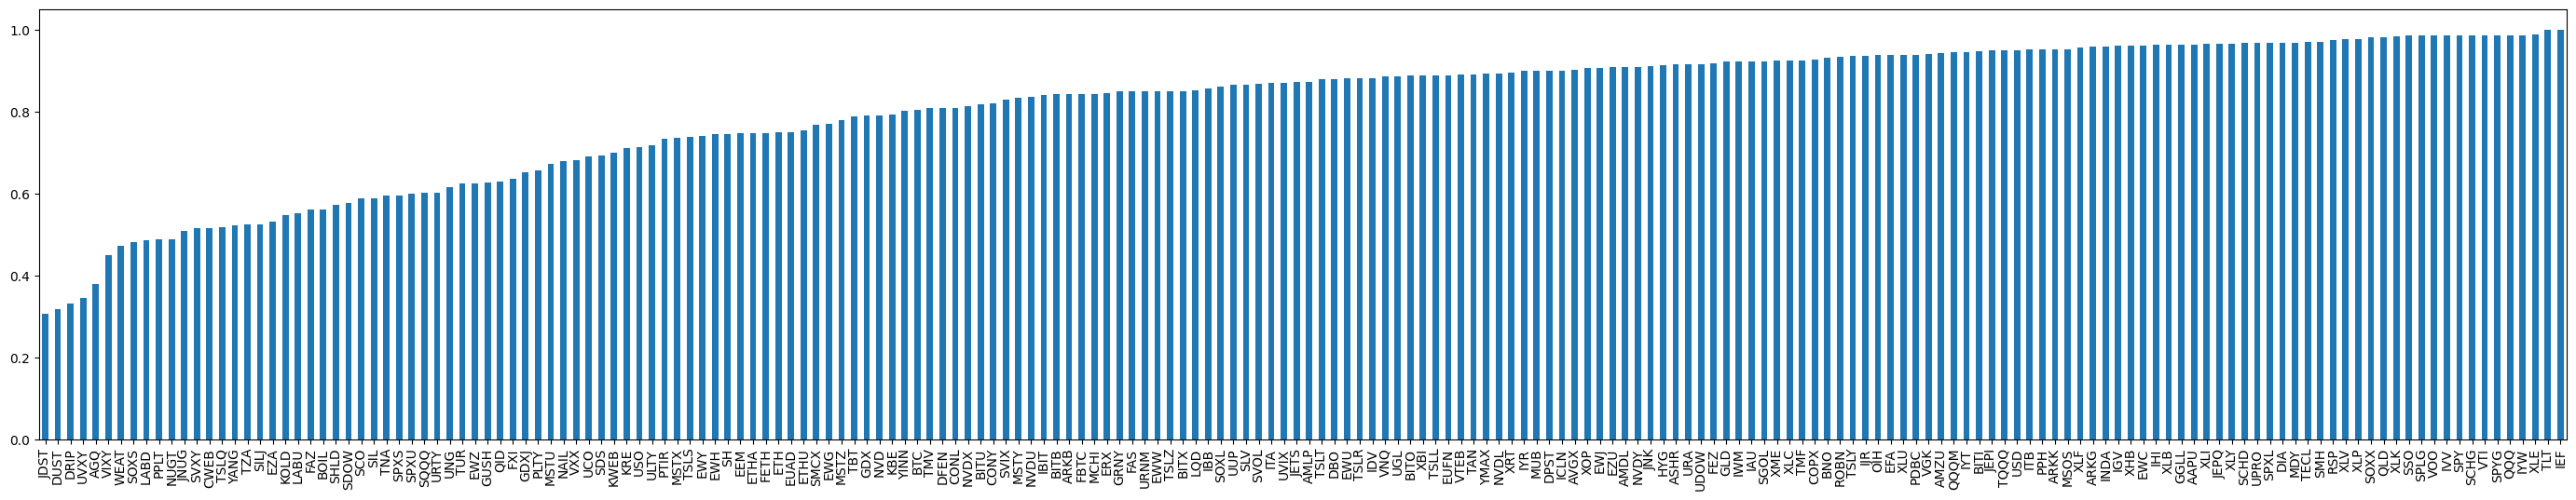

In [ ]:
plt.figure(figsize=(35, 6))
seri=pd.DataFrame(active_etf_corr).max(axis=0)#.plot.bar()#['NVDA']
seri= seri.sort_values().plot.bar()

<Axes: >

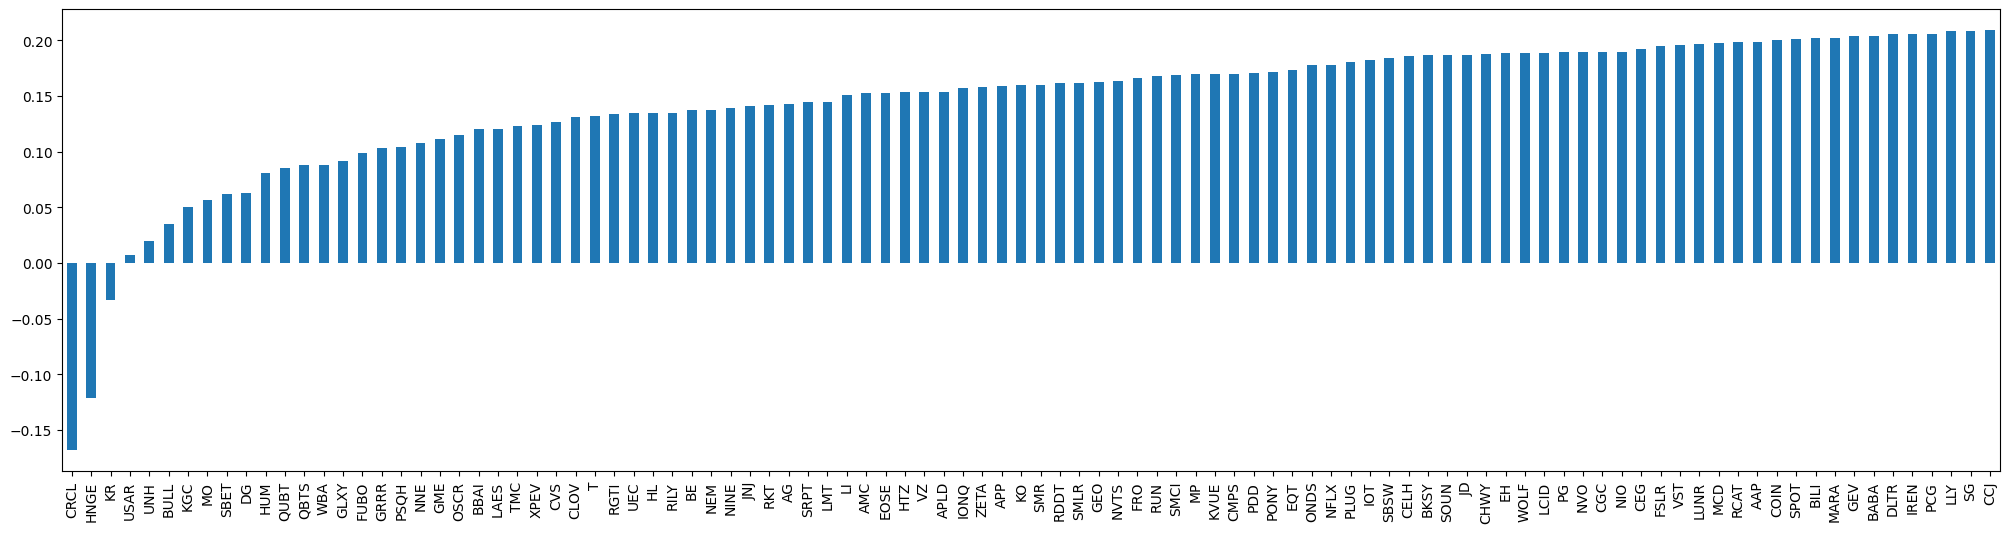

In [59]:
plt.figure(figsize=(25, 6))
seri=pd.DataFrame(active_stocks_corr).median(axis=0)#.plot.bar()#['NVDA']
seri.sort_values().head(100).plot.bar()

In [58]:
seri.loc['TSLA']

np.float64(0.25415761651064706)

In [40]:
seri.sort_values()

CRCL   -0.146264
HNGE   -0.098829
KR     -0.012946
USAR   -0.007481
BULL    0.041386
          ...   
NTRS    0.407891
QCOM    0.414986
AAPL    0.416698
SLB     0.421534
DOW     0.454954
Length: 300, dtype: float64

In [9]:
del all_price['TLT']
del all_price['IEF']

(<seaborn.matrix.ClusterGrid at 0x2970faa50>,
             DOW       SLB       OXY       CVX       XOM        SU        JD  \
 DOW    1.000000  0.656277  0.624570  0.575610  0.556992  0.556190  0.405514   
 SLB    0.656277  1.000000  0.772287  0.784465  0.763380  0.736092  0.260044   
 OXY    0.624570  0.772287  1.000000  0.820849  0.820426  0.771074  0.240235   
 CVX    0.575610  0.784465  0.820849  1.000000  0.831464  0.750821  0.221641   
 XOM    0.556992  0.763380  0.820426  0.831464  1.000000  0.769176  0.200982   
 SU     0.556190  0.736092  0.771074  0.750821  0.769176  1.000000  0.205936   
 JD     0.405514  0.260044  0.240235  0.221641  0.200982  0.205936  1.000000   
 VALE   0.534090  0.415224  0.370410  0.360036  0.333014  0.401265  0.540663   
 RIO    0.538551  0.437323  0.357064  0.401334  0.362612  0.407243  0.524313   
 MTCH   0.392594  0.324967  0.231810  0.262602  0.192250  0.185893  0.125010   
 UPS    0.611585  0.352781  0.376763  0.360658  0.305255  0.292692  0.1954

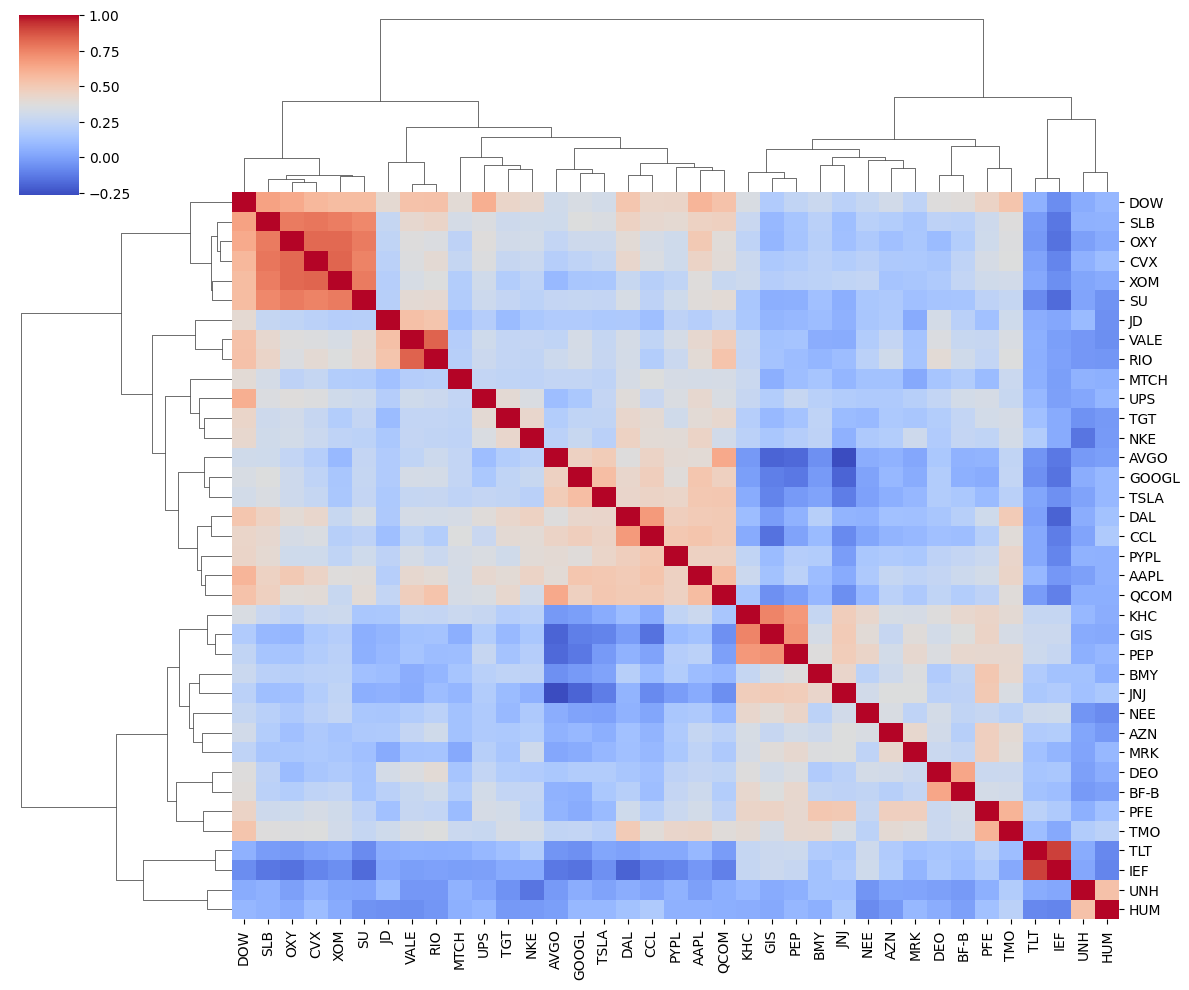

In [14]:
res_df=create_stock_correlation_network(all_price,252*1,output='df',transformation='log')
clustered_heatmap(res_df,cmap='coolwarm')

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Generate sample data
x = np.linspace(0, 4*np.pi, 100)
y = np.sin(x)

# Setup figure and axis
fig, ax = plt.subplots(figsize=(8,4))
line, = ax.plot([], [], lw=2)
ax.set_xlim(0, 4*np.pi)
ax.set_ylim(-1.1, 1.1)

# Animation functions
def init():
    line.set_data([], [])
    return line,

def update(frame):
    line.set_data(x[:frame], y[:frame])
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=len(x)+1,
                    init_func=init, blit=True,
                    interval=50)

# Save as MP4 video
writer = FFMpegWriter(fps=15, bitrate=1800)
ani.save("animation.mp4", writer=writer)
plt.close()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Generate static x-values (0 to 4π with 500 points)
x = np.linspace(0, 4*np.pi, 500)
t_values = np.linspace(0.1, 2, 200)  # Time parameter evolution

# Configure plot
fig, ax = plt.subplots(figsize=(10, 4))
line, = ax.plot([], [], lw=2, color='crimson')
ax.set_xlim(0, 4*np.pi)
ax.set_ylim(-1.1, 1.1)
ax.grid(alpha=0.4)

# Animation functions
def init():
    line.set_data([], [])
    return line,

def update(t):
    y = np.sin(x * t)  # Core equation y = sin(xt)
    line.set_data(x, y)
    ax.set_title(f'y = sin(xt) | t = {t:.2f}', fontsize=12)
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=t_values,
                    init_func=init, blit=True, interval=50)

# Save as video (requires FFmpeg)
writer = FFMpegWriter(fps=20, bitrate=2000)
ani.save("sine_evolution.mp4", writer=writer)
plt.close()


NameError: name 'downloader' is not defined

In [82]:
plot_network_and_heatmap(all_price,200)

Error: create_stock_correlation_network function not available


(None, None)

In [80]:
analyze_correlation_network(res,top_n=10)

{'num_nodes': 29,
 'num_edges': 406,
 'avg_correlation': np.float64(0.31968025438490366),
 'max_correlation': np.float64(0.9412442671096187),
 'min_correlation': np.float64(-0.8017368691514044),
 'top_correlations': [{'stocks': ('DOW', 'MRK'),
   'correlation': np.float64(0.9412442671096187)},
  {'stocks': ('DOW', 'TGT'), 'correlation': np.float64(0.9331598847811812)},
  {'stocks': ('DOW', 'PEP'), 'correlation': np.float64(0.9285619873561776)},
  {'stocks': ('PEP', 'MRK'), 'correlation': np.float64(0.9165853969994254)},
  {'stocks': ('DOW', 'PFE'), 'correlation': np.float64(0.8986140756135339)},
  {'stocks': ('DOW', 'NKE'), 'correlation': np.float64(0.8969778554075569)},
  {'stocks': ('PFE', 'MRK'), 'correlation': np.float64(0.888137615669571)},
  {'stocks': ('TGT', 'UPS'), 'correlation': np.float64(0.8880850861893352)},
  {'stocks': ('DOW', 'OXY'), 'correlation': np.float64(0.883548736338841)},
  {'stocks': ('OXY', 'SLB'), 'correlation': np.float64(0.8832685392449435)}]}

In [32]:
# def download_and_calculate_volatility(symbol, start_date, end_date, window=20):
#     """
#     Enhanced function to calculate both volatility measures
#     """
#     print(f"Downloading data for {symbol}...")
#     data = yf.download(symbol, start=start_date, end=end_date)
    
#     # Calculate both volatility measures
#     data['GK_Volatility'] = garman_klass_volatility(data, window)
#     data['YZ_Volatility'] = yang_zhang_volatility(data, window)
    
    # return data
def plot_volatility_comparison(data, symbol):
    """
    Enhanced visualization with both volatility measures and current values
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Price plot
    ax1.plot(data.index, data['Close'], label='Closing Price')
    ax1.set_title(f'{symbol} - Price and Volatility Comparison')
    ax1.set_ylabel('Price ($)')
    ax1.grid(True)
    
    # Get the latest volatility values
    latest_gk = data['GK_Volatility'].iloc[-1]
    latest_yz = data['YZ_Volatility'].iloc[-1]
    
    # Volatility comparison plot
    ax2.plot(data.index, data['GK_Volatility'], 
             label=f'Garman-Klass (Current: {latest_gk:.2%})', color='blue',alpha=0.5)
    ax2.plot(data.index, data['YZ_Volatility'], 
             label=f'Yang-Zhang (Current: {latest_yz:.2%})', color='red',alpha=0.3)
    ax2.axhline(y=latest_gk, color='blue', linestyle='--', alpha=1)
    ax2.axhline(y=latest_yz, color='red', linestyle='--', alpha=1)
    # Add text annotation with current values
    # ax2.text(0.02, 0.98, f'Latest Volatility:\nGK: {latest_gk:.2%}\nYZ: {latest_yz:.2%}', 
    #          transform=ax2.transAxes, verticalalignment='top',
    #          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax2.set_title('Volatility Comparison')
    ax2.set_ylabel('Annualized Volatility')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# # Example usage
# if __name__ == "__main__":
#     # Parameters
#     symbol = 'AAPL'
#     start_date = '2019-01-01'
#     end_date = '2025-05-22' 
#     window = 20
    
#     # Download data and calculate volatility
#     stock_data = download_and_calculate_gk_volatility(symbol, start_date, end_date, window)
    
#     # Display results
#     print(f"\nGarman-Klass Volatility for {symbol}:")
#     print("=" * 50)
#     print(stock_data[['Close', 'GK_Volatility']].tail(10))
    
#     # Calculate summary statistics
#     avg_volatility = stock_data['GK_Volatility'].mean()
#     min_volatility = stock_data['GK_Volatility'].min()
#     max_volatility = stock_data['GK_Volatility'].max()
    
#     print(f"\nSummary Statistics:")
#     print(f"Average Volatility: {avg_volatility:.4f}")
#     print(f"Minimum Volatility: {min_volatility:.4f}")
#     print(f"Maximum Volatility: {max_volatility:.4f}")
    
#     # Plot the results
#     plot_volatility(stock_data, symbol)
    
#     # Compare multiple stocks
#     symbols = ['AAPL', 'GOOGL', 'MSFT', 'TSLA']
#     comparison_data = {}
    
#     print(f"\nComparing Garman-Klass Volatility across stocks:")
#     print("=" * 60)
    
#     for stock in symbols:
#         try:
#             data = download_and_calculate_gk_volatility(stock, start_date, end_date, window)
#             latest_vol = data['GK_Volatility'].iloc[-1]
#             avg_vol = data['GK_Volatility'].mean()
#             comparison_data[stock] = {'Latest': latest_vol, 'Average': avg_vol}
#             print(f"{stock}: Latest = {latest_vol:.4f}, Average = {avg_vol:.4f}")
#         except Exception as e:
#             print(f"Error processing {stock}: {e}")
    
#     # Create comparison DataFrame
#     comparison_df = pd.DataFrame(comparison_data).T
#     print(f"\nVolatility Comparison:")
#     print(comparison_df.round(4))


In [3]:
ref_FOC = FOC()

In [9]:
def example_result_callback(result):
    print("Result from target function:", result)

In [12]:
def example_result_callback(result,ls):
    ls.append(result)
    raise Exception('stop')

In [21]:
ls=[]
ref_FOC.create_quote_stream_options_price_data(20,'AMC---250530C00003000',result_callback=lambda x:example_result_callback(x,ls))


Exception in thread Thread-54 (_run):
Traceback (most recent call last):
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/FOC/main.py", line 116, in json_extract_node
    json_data = json_data[key]
                ~~~~~~~~~^^^^^
TypeError: 'NoneType' object is not subscriptable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/FOC/intervalrunner.py", line 23, in _run
    result = self.target_func(*self.func_args)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/wil

In [23]:
ls=[]
ref_FOC.create_quote_stream_options_price_data(20,'AAPL--250530C00200000',result_callback=lambda x:example_result_callback(x,ls))


Exception in thread Thread-55 (_run):
Traceback (most recent call last):
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/FOC/intervalrunner.py", line 25, in _run
    self.result_callback(result)
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/2323725644.py", line 2, in <lambda>
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/3823222416.py", line 3, in example_result_callback
Exception: stop


In [24]:
ls[0]

label,Last Sale,Net,Day High,Day Low,Volume,Prev Close,Open,Open Interest,Tick,Bid,...,Contract Low,Market,Delta,Gamma,Rho,Theta,Vega,Impvol,timestamp,contract_symbol
AAPL--250530C00200000,,,,,,,,,,,,,,,,,,,,,
value,1.62,-2.68,2.64,1.41,25575,4.3,1.53,3540,,1.6,...,1.41,OPRAC,0.30546,0.04101,0.01112,-0.21995,0.09476,0.31613,2025-05-25 15:42:00,AAPL--250530C00200000


In [26]:
ls=[]
ref_FOC.create_quote_stream_options_price_data(20,'TSLA--250530C00440000',result_callback=lambda x:example_result_callback(x,ls))


Exception in thread Thread-57 (_run):
Traceback (most recent call last):
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/FOC/intervalrunner.py", line 25, in _run
    self.result_callback(result)
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/1577127683.py", line 2, in <lambda>
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/3823222416.py", line 3, in example_result_callback
Exception: stop


In [41]:
ls[0]

,price,nlsShareVolume,nlsTime,nlsVolume,previousClose,todayHighLow,fiftyTwoWeekHighLow
0,195.27,850.0,16:00:00,"78,432,918",$201.36,/,$260.1/$169.2101


In [39]:
ls=[]
ref_FOC.create_quote_stream_stock_price(20,'AAPL',last_n_price = 50,result_callback=lambda x:example_result_callback(x,ls))


Exception in thread Thread-74 (_run):
Traceback (most recent call last):
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/williamxu/anaconda3/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/williamxu/anaconda3/lib/python3.11/site-packages/FOC/intervalrunner.py", line 25, in _run
    self.result_callback(result)
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/625373052.py", line 2, in <lambda>
  File "/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_81809/3823222416.py", line 3, in example_result_callback
Exception: stop


In [28]:
ref_FOC = FOC()

# Options Chain of AAPL CALL options for 6 October 2023
options_chain = ref_FOC.get_options_chain("AAPL","2023-10-06",OptionType.CALL)

TypeError: FOC.get_options_chain() missing 2 required positional arguments: 'expiration_date' and 'option_type'

Processing data request for TGT from 2007-01-03 to 2025-06-18...
Found cached data for TGT (last updated: 2025-06-20 16:00:07)
All requested data for TGT available in cache!


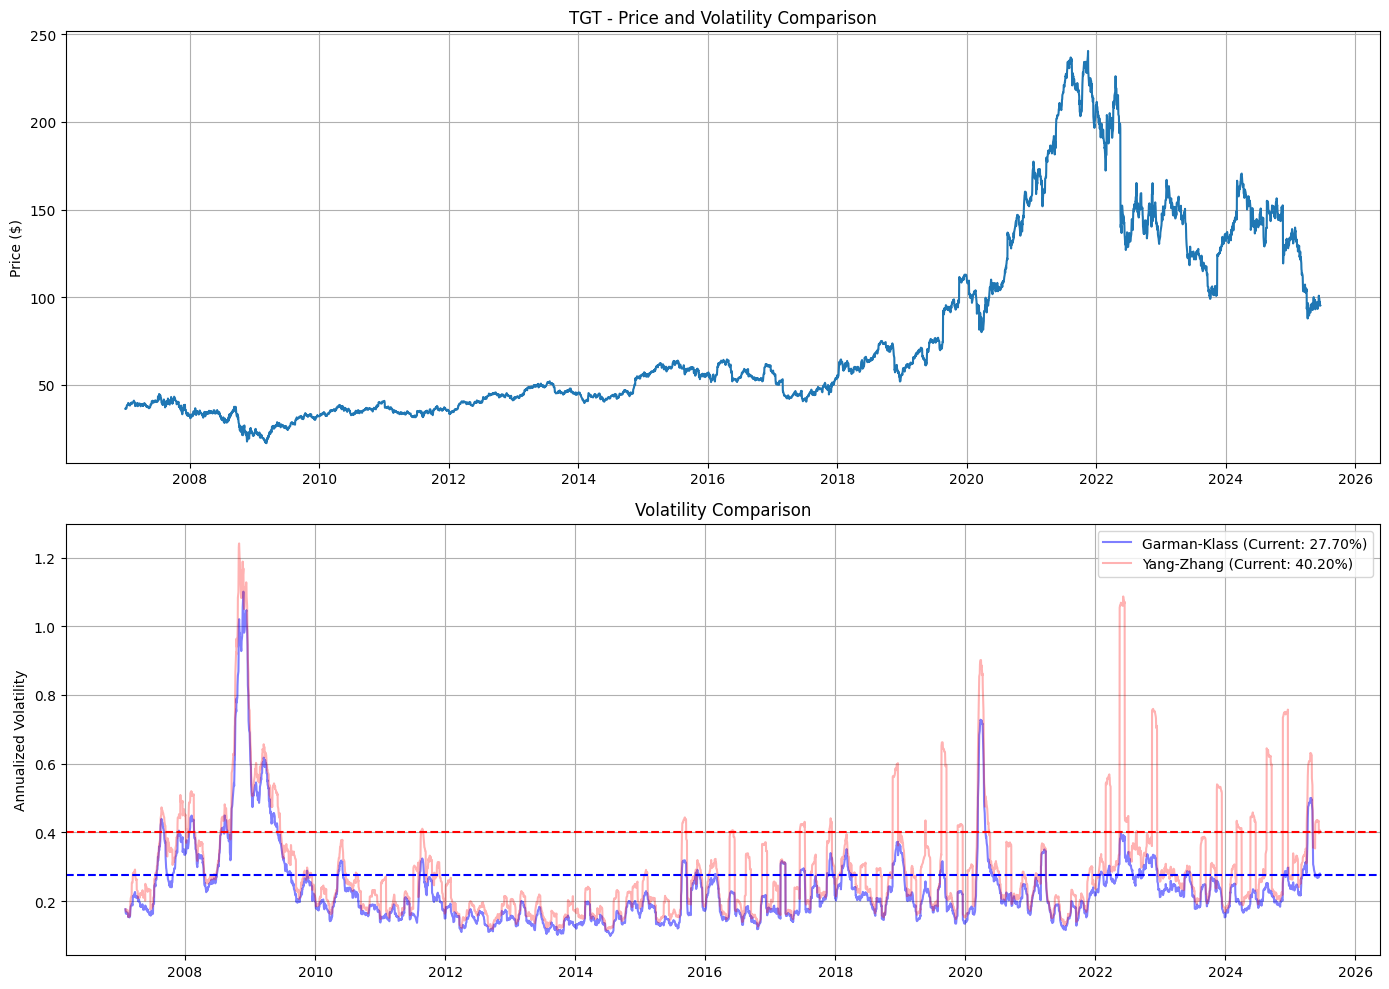

TGT: YZ-pval: 0.149,  GK-pval: 0.206


/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_16333/2872722370.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_pval=lambda s: larger_proportion(s.dropna(),s[-1])


In [35]:
stock='TGT'
res_dict=dict()
window=20
p_val=dict()
try:
    data =  downloader(stock, start_date,end_date)
    data['GK_Volatility'] = garman_klass_volatility(data, window)
    data['YZ_Volatility'] = yang_zhang_volatility(data, window)
    plot_volatility_comparison(data, stock)
    #larger_proportion(res_dict[stock]['YZ_Volatility'].dropna(),0.5)
    # comparison_data[stock] = {
    #     'GK_Mean': data['GK_Volatility'].mean(),
    #     'YZ_Mean': data['YZ_Volatility'].mean(),
    #     'Volatility_Ratio': data['YZ_Volatility'].mean() / data['GK_Volatility'].mean()
    # }
    res_dict[stock]=data
except Exception as e:
    print(f"Error processing {stock}: {e}")

for stock,data in res_dict.items():
    p_val[stock]={"YZ-pval":latest_pval(data['YZ_Volatility']),"GK-pval":latest_pval(data['GK_Volatility'])}
    print('{}: YZ-pval: {:.3f},  GK-pval: {:.3f}'.format(stock,p_val[stock]["YZ-pval"], p_val[stock]["GK-pval"]))

In [ ]:
cached = list_cached_symbols()
for info in cached:
    print(f"Symbol: {info['symbol']}")
    print(f"  Date Range: {info['date_range']}")
    print(f"  Records: {info['records']}")
    print(f"  Last Updated: {info['last_update']}")
    print(f"  File Size: {info['file_size']}")

Symbol: AAPL
  Date Range: 2022-01-03 to 2024-01-30
  Records: 521
  Last Updated: 2025-05-30 16:36:41.351814
  File Size: 25.8 KB


In [175]:
data2 = downloader("AAPL", "2023-06-01", "2025-05-31")

Processing data request for AAPL from 2023-06-01 to 2025-05-31...
Found cached data for AAPL (last updated: 2025-05-31 20:01:03)
Fetching missing data for AAPL: 2025-05-30 to 2025-05-31


[*********************100%***********************]  1 of 1 completed

Data download complete for AAPL. Shape: (501, 5)


In [12]:
# In main execution block
#stock_data = download_and_calculate_volatility(symbol, start_date, end_date)
#stock='DAL'#'603299.SS'
# Enhanced multi-stock comparison
#symbols = [stock]#['603100.SS']#['9979.HK']#['TSLA','AVGO']#['PEP','MRK','BMY','TSLA']#['PFE','DAL','OXY']#['AAPL', 'GOOGL', 'MSFT', 'TSLA']
comparison_data = {}

window = 20
res_dict=dict()
p_val=dict()



for stock in symbols:
    try:
        data =  downloader(stock, start_date,end_date)
        data['GK_Volatility'] = garman_klass_volatility(data, window)
        data['YZ_Volatility'] = yang_zhang_volatility(data, window)
        #plot_volatility_comparison(data, stock)
        #larger_proportion(res_dict[stock]['YZ_Volatility'].dropna(),0.5)
        # comparison_data[stock] = {
        #     'GK_Mean': data['GK_Volatility'].mean(),
        #     'YZ_Mean': data['YZ_Volatility'].mean(),
        #     'Volatility_Ratio': data['YZ_Volatility'].mean() / data['GK_Volatility'].mean()
        # }
        res_dict[stock]=data
    except Exception as e:
        print(f"Error processing {stock}: {e}")

for stock,data in res_dict.items():
    p_val[stock]={"YZ-pval":latest_pval(data['YZ_Volatility']),"GK-pval":latest_pval(data['GK_Volatility'])}
    print('{}: YZ-pval: {:.3f},  GK-pval: {:.3f}'.format(stock,p_val[stock]["YZ-pval"], p_val[stock]["GK-pval"]))
# comparison_df = pd.DataFrame(comparison_data).T
# print("\nMulti-Stock Volatility Analysis:")
# print(comparison_df.round(4))


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Processing data request for AAPL from 2007-01-01 to 2025-06-03...
Found cached data for AAPL (last updated: 2025-06-02 09:55:43)
Fetching missing data for AAPL: 2007-01-01 to 2007-01-02
Fetching missing data for AAPL: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for AAPL. Shape: (4633, 5)
Processing data request for PYPL from 2007-01-01 to 2025-06-03...
Found cached data for PYPL (last updated: 2025-06-02 14:57:55)
Fetching missing data for PYPL: 2007-01-01 to 2015-07-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PYPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2015-07-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1436068800")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GOOGL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Fetching missing data for PYPL: 2025-05-31 to 2025-06-03
Data download complete for PYPL. Shape: (2493, 5)
Processing data request for GOOGL from 2007-01-01 to 2025-06-03...
Found cached data for GOOGL (last updated: 2025-06-02 09:55:44)
Fetching missing data for GOOGL: 2007-01-01 to 2007-01-02
Fetching missing data for GOOGL: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['QCOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for GOOGL. Shape: (4633, 5)
Processing data request for QCOM from 2007-01-01 to 2025-06-03...
Found cached data for QCOM (last updated: 2025-06-02 09:55:44)
Fetching missing data for QCOM: 2007-01-01 to 2007-01-02
Fetching missing data for QCOM: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MTCH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for QCOM. Shape: (4633, 5)
Processing data request for MTCH from 2007-01-01 to 2025-06-03...
Found cached data for MTCH (last updated: 2025-06-02 09:55:44)
Fetching missing data for MTCH: 2007-01-01 to 2007-01-02
Fetching missing data for MTCH: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for MTCH. Shape: (4633, 5)
Processing data request for DOW from 2007-01-01 to 2025-06-03...
Found cached data for DOW (last updated: 2025-06-02 09:55:44)
Fetching missing data for DOW: 2007-01-01 to 2019-03-19


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DOW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2019-03-19) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1552968000")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for DOW: 2025-05-31 to 2025-06-03
Data download complete for DOW. Shape: (1560, 5)
Processing data request for XOM from 2007-01-01 to 2025-06-03...
Found cached data for XOM (last updated: 2025-06-02 09:55:45)
Fetching missing data for XOM: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['XOM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Fetching missing data for XOM: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for XOM. Shape: (4633, 5)
Processing data request for OXY from 2007-01-01 to 2025-06-03...
Found cached data for OXY (last updated: 2025-06-02 09:55:45)
Fetching missing data for OXY: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['OXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for OXY: 2025-05-31 to 2025-06-03
Data download complete for OXY. Shape: (4633, 5)
Processing data request for CVX from 2007-01-01 to 2025-06-03...
Found cached data for CVX (last updated: 2025-06-02 09:55:46)
Fetching missing data for CVX: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['CVX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for CVX: 2025-05-31 to 2025-06-03
Data download complete for CVX. Shape: (4633, 5)
Processing data request for SLB from 2007-01-01 to 2025-06-03...
Found cached data for SLB (last updated: 2025-06-02 09:55:46)
Fetching missing data for SLB: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SLB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Fetching missing data for SLB: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for SLB. Shape: (4633, 5)
Processing data request for SU from 2007-01-01 to 2025-06-03...
Found cached data for SU (last updated: 2025-06-02 09:55:46)
Fetching missing data for SU: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for SU: 2025-05-31 to 2025-06-03
Data download complete for SU. Shape: (4633, 5)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TGT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TGT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-06-03 -> 2025-06-03)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UPS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Processing data request for TGT from 2007-01-01 to 2025-06-03...
Found cached data for TGT (last updated: 2025-06-04 15:48:15)
Fetching missing data for TGT: 2007-01-01 to 2007-01-02
Fetching missing data for TGT: 2025-06-03 to 2025-06-03
Data download complete for TGT. Shape: (4633, 5)
Processing data request for UPS from 2007-01-01 to 2025-06-03...
Found cached data for UPS (last updated: 2025-06-02 09:55:47)
Fetching missing data for UPS: 2007-01-01 to 2007-01-02
Fetching missing data for UPS: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NEE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for UPS. Shape: (4633, 5)
Processing data request for NEE from 2007-01-01 to 2025-06-03...
Found cached data for NEE (last updated: 2025-06-02 09:55:47)
Fetching missing data for NEE: 2007-01-01 to 2007-01-02
Fetching missing data for NEE: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PEP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for NEE. Shape: (4633, 5)
Processing data request for PEP from 2007-01-01 to 2025-06-03...
Found cached data for PEP (last updated: 2025-06-02 09:55:48)
Fetching missing data for PEP: 2007-01-01 to 2007-01-02
Fetching missing data for PEP: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for PEP. Shape: (4633, 5)
Processing data request for AZN from 2007-01-01 to 2025-06-03...
Found cached data for AZN (last updated: 2025-06-03 15:28:30)
Fetching missing data for AZN: 2007-01-01 to 2007-01-02
Fetching missing data for AZN: 2025-06-03 to 2025-06-03


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AZN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-06-03 -> 2025-06-03)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for AZN. Shape: (4633, 5)
Processing data request for PFE from 2007-01-01 to 2025-06-03...
Found cached data for PFE (last updated: 2025-06-03 15:11:50)
Fetching missing data for PFE: 2007-01-01 to 2007-01-02
Fetching missing data for PFE: 2025-06-03 to 2025-06-03


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-06-03 -> 2025-06-03)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MRK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Data download complete for PFE. Shape: (4633, 5)
Processing data request for MRK from 2007-01-01 to 2025-06-03...
Found cached data for MRK (last updated: 2025-06-02 09:55:48)
Fetching missing data for MRK: 2007-01-01 to 2007-01-02
Fetching missing data for MRK: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for MRK. Shape: (4633, 5)
Processing data request for BMY from 2007-01-01 to 2025-06-03...
Found cached data for BMY (last updated: 2025-06-02 14:56:01)
Fetching missing data for BMY: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BMY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for BMY: 2025-05-31 to 2025-06-03
Data download complete for BMY. Shape: (4633, 5)
Processing data request for UNH from 2007-01-01 to 2025-06-03...
Found cached data for UNH (last updated: 2025-06-02 09:55:49)
Fetching missing data for UNH: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['UNH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for UNH: 2025-05-31 to 2025-06-03
Data download complete for UNH. Shape: (4633, 5)
Processing data request for VALE from 2007-01-01 to 2025-06-03...
Found cached data for VALE (last updated: 2025-06-02 09:55:49)
Fetching missing data for VALE: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VALE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')


Fetching missing data for VALE: 2025-05-31 to 2025-06-03


[*********************100%***********************]  1 of 1 completed


Data download complete for VALE. Shape: (4633, 5)
Processing data request for RIO from 2007-01-01 to 2025-06-03...
Found cached data for RIO (last updated: 2025-06-03 15:09:09)
Fetching missing data for RIO: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['RIO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-06-03 -> 2025-06-03)')


Fetching missing data for RIO: 2025-06-03 to 2025-06-03
Data download complete for RIO. Shape: (4633, 5)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['JD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2014-05-21) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1400644800")')


Processing data request for JD from 2007-01-01 to 2025-06-03...
Found cached data for JD (last updated: 2025-06-02 09:55:50)
Fetching missing data for JD: 2007-01-01 to 2014-05-21


[*********************100%***********************]  1 of 1 completed


Fetching missing data for JD: 2025-05-31 to 2025-06-03
Data download complete for JD. Shape: (2774, 5)
Processing data request for TSLA from 2007-01-01 to 2025-06-03...
Found cached data for TSLA (last updated: 2025-06-02 09:55:50)
Fetching missing data for TSLA: 2007-01-01 to 2010-06-28


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2010-06-28) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1277697600")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for TSLA: 2025-05-31 to 2025-06-03
Data download complete for TSLA. Shape: (3755, 5)
Processing data request for AVGO from 2007-01-01 to 2025-06-03...
Found cached data for AVGO (last updated: 2025-06-02 09:55:51)
Fetching missing data for AVGO: 2007-01-01 to 2009-08-05


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AVGO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2009-08-05) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1249444800")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for AVGO: 2025-05-31 to 2025-06-03
Data download complete for AVGO. Shape: (3980, 5)
Processing data request for TLT from 2007-01-01 to 2025-06-03...
Found cached data for TLT (last updated: 2025-06-02 09:55:51)
Fetching missing data for TLT: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for TLT: 2025-05-31 to 2025-06-03
Data download complete for TLT. Shape: (4633, 5)
Processing data request for IEF from 2007-01-01 to 2025-06-03...
Found cached data for IEF (last updated: 2025-06-02 09:55:51)
Fetching missing data for IEF: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['IEF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for IEF: 2025-05-31 to 2025-06-03
Data download complete for IEF. Shape: (4633, 5)
Processing data request for DAL from 2007-01-01 to 2025-06-03...
Found cached data for DAL (last updated: 2025-06-02 14:41:10)
Fetching missing data for DAL: 2007-01-01 to 2007-05-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['DAL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-05-02) (Yahoo error = "Data doesn\'t exist for startDate = 1167627600, endDate = 1178078400")')
[*********************100%***********************]  1 of 1 completed


Fetching missing data for DAL: 2025-05-31 to 2025-06-03
Data download complete for DAL. Shape: (4550, 5)
Processing data request for NKE from 2007-01-01 to 2025-06-03...
Found cached data for NKE (last updated: 2025-06-02 09:55:52)
Fetching missing data for NKE: 2007-01-01 to 2007-01-02


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NKE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed
/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_56405/3330865663.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_pval=lambda s: larger_proportion(s.dropna(),s[-1])


Fetching missing data for NKE: 2025-05-31 to 2025-06-03
Data download complete for NKE. Shape: (4633, 5)
AAPL: YZ-pval: 0.183,  GK-pval: 0.406
PYPL: YZ-pval: 0.628,  GK-pval: 0.816
GOOGL: YZ-pval: 0.135,  GK-pval: 0.074
QCOM: YZ-pval: 0.341,  GK-pval: 0.551
MTCH: YZ-pval: 0.449,  GK-pval: 0.443
DOW: YZ-pval: 0.101,  GK-pval: 0.353
XOM: YZ-pval: 0.429,  GK-pval: 0.569
OXY: YZ-pval: 0.337,  GK-pval: 0.519
CVX: YZ-pval: 0.437,  GK-pval: 0.617
SLB: YZ-pval: 0.436,  GK-pval: 0.670
SU: YZ-pval: 0.541,  GK-pval: 0.650
TGT: YZ-pval: 0.119,  GK-pval: 0.233
UPS: YZ-pval: 0.263,  GK-pval: 0.500
NEE: YZ-pval: 0.076,  GK-pval: 0.070
PEP: YZ-pval: 0.512,  GK-pval: 0.439
AZN: YZ-pval: 0.388,  GK-pval: 0.338
PFE: YZ-pval: 0.457,  GK-pval: 0.397
MRK: YZ-pval: 0.135,  GK-pval: 0.142
BMY: YZ-pval: 0.251,  GK-pval: 0.177
UNH: YZ-pval: 0.021,  GK-pval: 0.045
VALE: YZ-pval: 0.959,  GK-pval: 0.988
RIO: YZ-pval: 0.946,  GK-pval: 0.946
JD: YZ-pval: 0.654,  GK-pval: 0.868
TSLA: YZ-pval: 0.380,  GK-pval: 0.565
A

In [11]:
# Define trading days for different periods
# Approximate trading days (assuming ~252 trading days per year)
periods = {
    "3M": 63,    # 3 months ≈ 63 trading days
    "6M": 126,   # 6 months ≈ 126 trading days
    "1Y": 252,   # 1 year ≈ 252 trading days
    "3Y": 756,   # 3 years ≈ 756 trading days
    "5Y": 1260,  # 5 years ≈ 1260 trading days
    "10Y": 2520  # 10 years ≈ 2520 trading days
}

# Option 1: Analyze all periods for each stock
for stock, data in res_dict.items():
    #print(f"\n{stock}:")
    p_val[stock] = {}
    
    for period_name, days in periods.items():
        # Slice the data to get the last N trading days
        recent_data = data.tail(days)
        
        # Calculate p-values for the restricted period
        yz_pval = latest_pval(recent_data['YZ_Volatility'])
        #gk_pval = latest_pval(recent_data['GK_Volatility'])
        
        p_val[stock][f"{period_name}_YZ-pval"] = yz_pval
        #p_val[stock][f"{period_name}_GK-pval"] = gk_pval
        
        #print(f'  {period_name}: YZ-pval: {yz_pval:.3f}, GK-pval: {gk_pval:.3f}')

# Option 2: Analyze a specific period only (e.g., last 1 year)
# selected_period = "1Y"  # Change this to desired period
# selected_days = periods[selected_period]

# print(f"\n=== Analysis for Last {selected_period} ===")
# p_val_period = {}

# for stock, data in res_dict.items():
#     # Restrict to selected period
#     recent_data = data.tail(selected_days)
    
#     p_val_period[stock] = {
#         "YZ-pval": latest_pval(recent_data['YZ_Volatility']),
#         "GK-pval": latest_pval(recent_data['GK_Volatility'])
#     }
    
#     print('{}: YZ-pval: {:.3f}, GK-pval: {:.3f}'.format(
#         stock, 
#         p_val_period[stock]["YZ-pval"], 
#         p_val_period[stock]["GK-pval"]
#     ))

# # Option 3: Function to get analysis for any specific period
# def analyze_period(res_dict, period_days, period_name=""):
#     """Analyze volatility p-values for a specific time period"""
#     results = {}
    
#     if period_name:
#         print(f"\n=== Analysis for {period_name} ===")
    
#     for stock, data in res_dict.items():
#         # Ensure we don't try to slice more data than available
#         actual_days = min(period_days, len(data))
#         recent_data = data.tail(actual_days)
        
#         results[stock] = {
#             "YZ-pval": latest_pval(recent_data['YZ_Volatility']),
#             "GK-pval": latest_pval(recent_data['GK_Volatility']),
#             #"data_points": len(recent_data)
#         }
        
#         print('{}: YZ-pval: {:.3f}, GK-pval: {:.3f} (n={})'.format(
#             stock, 
#             results[stock]["YZ-pval"], 
#             results[stock]["GK-pval"],
#             len(recent_data)
#             #results[stock]["data_points"]
#         ))
    
#     return results

# # Example usage of the function
# results_1y = analyze_period(res_dict, periods["1Y"], "Last 1 Year")
# results_3m = analyze_period(res_dict, periods["6M"], "Last 3 Months")

/var/folders/_q/zvg1j91x7sx_8_rt3f62v0ph0000gn/T/ipykernel_68520/3330865663.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  latest_pval=lambda s: larger_proportion(s.dropna(),s[-1])


In [12]:
p_val['XOM']

{'3M_YZ-pval': 0.9206349206349206,
 '6M_YZ-pval': 0.4603174603174603,
 '1Y_YZ-pval': 0.3253968253968254,
 '3Y_YZ-pval': 0.49206349206349204,
 '5Y_YZ-pval': 0.6674603174603174,
 '10Y_YZ-pval': 0.43214285714285716}

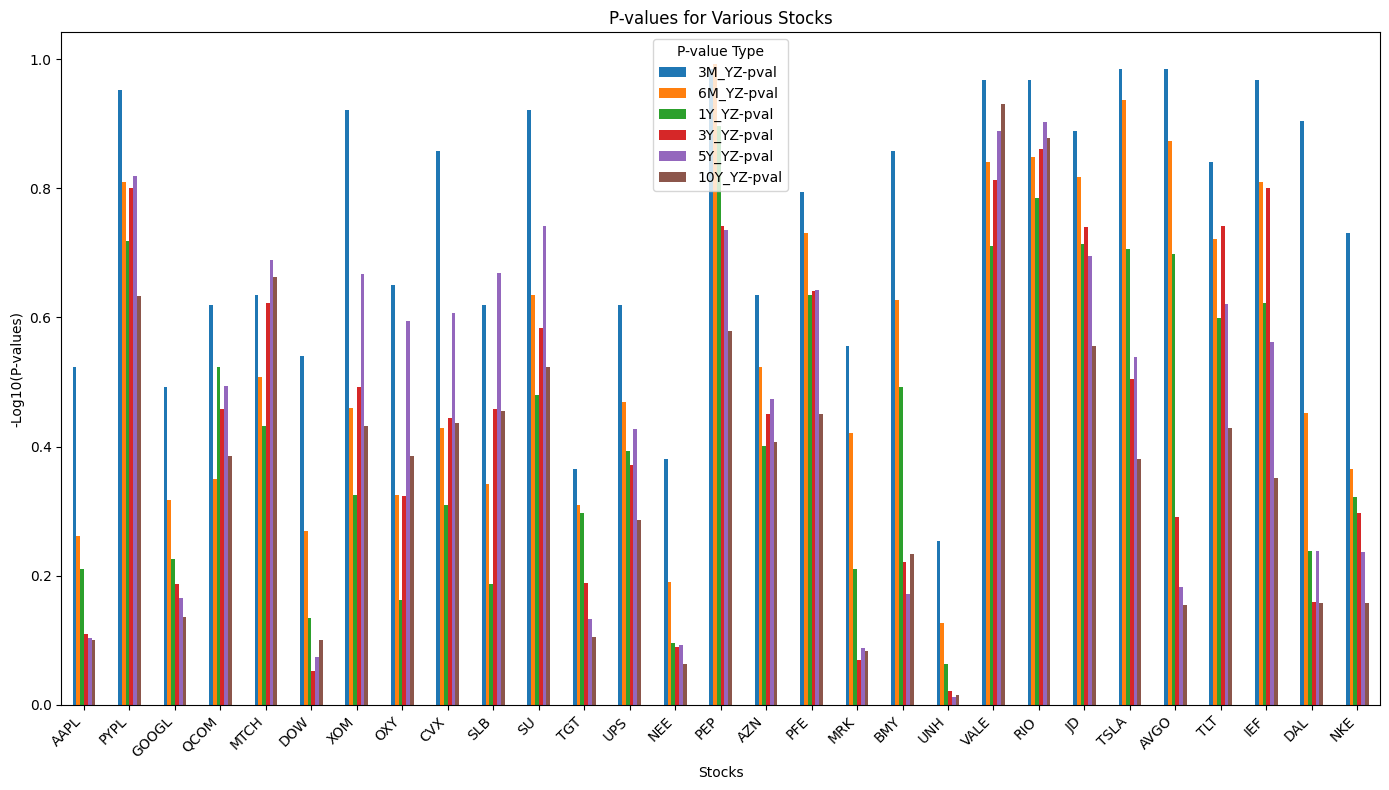

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert the data into a DataFrame
df = pd.DataFrame(p_val).T

# Apply -log10 transformation to the p-values
#df_log = -np.log10(df)
df_log=df
# Plotting the transformed values
fig, ax = plt.subplots(figsize=(14, 8))
df_log.plot(kind='bar', ax=ax)

# Adding labels and title
plt.title("P-values for Various Stocks")#-Log10 Transformed 
plt.xlabel("Stocks")
plt.ylabel("-Log10(P-values)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='P-value Type')
plt.tight_layout()

# Show plot
plt.show()


In [212]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class KDJCrossoverDetector:
    def __init__(self, data,n=9, m1=3, m2=3):
        """
        Initialize KDJ Crossover Detector
        
        Parameters:
        symbol: Stock symbol (e.g., 'AAPL', 'TSLA')
        period: Data period ('1y', '2y', '5y', 'max', etc.)
        n: Period for %K calculation (default: 9)
        m1: Smoothing period for %K (default: 3)
        m2: Smoothing period for %D (default: 3)
        """
        self.n = n
        self.m1 = m1
        self.m2 = m2
        self.data = data
        self.kdj_data = None
        self.symbol=data.columns[0][1]
    
    def calculate_kdj(self):
        """Calculate KDJ indicator"""
        if self.data is None:
            print("No data available. Please fetch data first.")
            return None
        
        df = self.data.copy()
        
        # Ensure all price columns are numeric
        # for col in ['High', 'Low', 'Close']:
        #     df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Remove any rows with NaN values in price data
        df.columns=[i[0] for i in df.columns]
        #print(df)
        #df = df.dropna(subset=['High', 'Low', 'Close'])
        
        # Calculate RSV (Raw Stochastic Value)
        low_n = df['Low'].rolling(window=self.n).min()
        high_n = df['High'].rolling(window=self.n).max()
        
        # Calculate RSV with proper handling of division by zero
        denominator = high_n - low_n
        rsv = np.where(denominator != 0, 100 * (df['Close'] - low_n) / denominator, 50)
        rsv = pd.Series(rsv, index=df.index)
        
        # Initialize K, D, J series
        k_values = []
        d_values = []
        j_values = []
        
        # Initial values
        k_prev = 50.0  # Starting value for K
        d_prev = 50.0  # Starting value for D
        
        for i, rsv_val in enumerate(rsv):
            # Ensure rsv_val is numeric
            if pd.isna(rsv_val) or not isinstance(rsv_val, (int, float)):
                rsv_val = 50.0
            else:
                rsv_val = float(rsv_val)
            
            # Calculate K: K = (2/3) * K_prev + (1/3) * RSV
            k_curr = (2.0/3.0) * float(k_prev) + (1.0/3.0) * rsv_val
            
            # Calculate D: D = (2/3) * D_prev + (1/3) * K
            d_curr = (2.0/3.0) * float(d_prev) + (1.0/3.0) * k_curr
            
            # Calculate J: J = 3*K - 2*D
            j_curr = 3.0 * k_curr - 2.0 * d_curr
            
            k_values.append(k_curr)
            d_values.append(d_curr)
            j_values.append(j_curr)
            
            k_prev = k_curr
            d_prev = d_curr
        
        # Add KDJ to dataframe
        df['K'] = k_values
        df['D'] = d_values
        df['J'] = j_values
        df['RSV'] = rsv
        
        self.kdj_data = df
        return df
    
    def detect_crossovers(self):
        """Detect KDJ crossover signals"""
        if self.kdj_data is None:
            print("KDJ data not calculated. Please calculate KDJ first.")
            return None
        
        df = self.kdj_data.copy()
        
        # Calculate crossover signals
        df['K_cross_D'] = np.where(
            (df['K'].shift(1) <= df['D'].shift(1)) & (df['K'] > df['D']), 1,
            np.where((df['K'].shift(1) >= df['D'].shift(1)) & (df['K'] < df['D']), -1, 0)
        )
        
        df['K_cross_J'] = np.where(
            (df['K'].shift(1) <= df['J'].shift(1)) & (df['K'] > df['J']), 1,
            np.where((df['K'].shift(1) >= df['J'].shift(1)) & (df['K'] < df['J']), -1, 0)
        )
        
        df['D_cross_J'] = np.where(
            (df['D'].shift(1) <= df['J'].shift(1)) & (df['D'] > df['J']), 1,
            np.where((df['D'].shift(1) >= df['J'].shift(1)) & (df['D'] < df['J']), -1, 0)
        )
        
        # Golden Cross (bullish): K crosses above D
        df['Golden_Cross'] = (df['K_cross_D'] == 1)
        
        # Death Cross (bearish): K crosses below D
        df['Death_Cross'] = (df['K_cross_D'] == -1)
        
        # Additional signals
        df['Bullish_Signal'] = (
            (df['K_cross_D'] == 1) | 
            ((df['K'] > df['D']) & (df['J'] > df['K']) & (df['K'] > 20))
        )
        
        df['Bearish_Signal'] = (
            (df['K_cross_D'] == -1) | 
            ((df['K'] < df['D']) & (df['J'] < df['K']) & (df['K'] < 80))
        )
        
        self.kdj_data = df
        return df

    def get_crossover_summary(self, days=30):
        """Get summary of recent crossover signals"""
        if self.kdj_data is None:
            return "No KDJ data available"
        
        recent_data = self.kdj_data.tail(days)
        
        golden_crosses = recent_data[recent_data['Golden_Cross']].index.tolist()
        death_crosses = recent_data[recent_data['Death_Cross']].index.tolist()
        
        summary = f"\n=== KDJ Crossover Summary for {self.symbol} (Last {days} days) ===\n"
        
        if golden_crosses:
            summary += f"Golden Crosses (Bullish): {len(golden_crosses)}\n"
            for date in golden_crosses[-3:]:  # Show last 3
                k_val = recent_data.loc[date, 'K']
                d_val = recent_data.loc[date, 'D']
                summary += f"  - {date.strftime('%Y-%m-%d')}: K({k_val:.2f}) crossed above D({d_val:.2f})\n"
        
        if death_crosses:
            summary += f"Death Crosses (Bearish): {len(death_crosses)}\n"
            for date in death_crosses[-3:]:  # Show last 3
                k_val = recent_data.loc[date, 'K']
                d_val = recent_data.loc[date, 'D']
                summary += f"  - {date.strftime('%Y-%m-%d')}: K({k_val:.2f}) crossed below D({d_val:.2f})\n"
        return summary
        
        # Current values
    def signalling(self,parameter=2):
        latest = self.kdj_data.iloc[-1]
        summary=''
        summary += f"\nCurrent Values ({latest.name.strftime('%Y-%m-%d')}):\n"
        summary += f"  K: {latest['K']:.2f}\n"
        summary += f"  D: {latest['D']:.2f}\n"
        summary += f"  J: {latest['J']:.2f}\n"
        summary += f"  Price: ${latest['Close']:.2f}\n"
        
        # Check if K, D, J values are very close (within 1 point)
        k_val = latest['K']
        d_val = latest['D']
        j_val = latest['J']
        
        kd_diff = abs(k_val - d_val)
        kj_diff = abs(k_val - j_val)
        dj_diff = abs(d_val - j_val)
        
        summary=None
        if (kd_diff <= parameter) or (kj_diff <= parameter) or (dj_diff <= parameter):
            summary =f"\n⚠️  WARNING: KDJ values are converging!\n"
            summary += f"   K-D difference: {kd_diff:.2f}\n"
            summary += f"   K-J difference: {kj_diff:.2f}\n"
            summary += f"   D-J difference: {dj_diff:.2f}\n"
            summary += f"   This may indicate an upcoming crossover or period of indecision.\n"
        
        return summary
    
    def plot_kdj(self, days=60):
        """Plot KDJ indicator with crossover signals"""
        if self.kdj_data is None:
            print("No KDJ data to plot")
            return
        
        recent_data = self.kdj_data.tail(days)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                                       gridspec_kw={'height_ratios': [2, 1]})
        
        # Plot price and signals
        ax1.plot(recent_data.index, recent_data['Close'], label='Close Price', linewidth=2)
        
        # Mark crossover points
        golden_crosses = recent_data[recent_data['Golden_Cross']]
        death_crosses = recent_data[recent_data['Death_Cross']]
        
        if not golden_crosses.empty:
            ax1.scatter(golden_crosses.index, golden_crosses['Close'], 
                       color='green', marker='^', s=100, label='Golden Cross', zorder=5)
        
        if not death_crosses.empty:
            ax1.scatter(death_crosses.index, death_crosses['Close'], 
                       color='red', marker='v', s=100, label='Death Cross', zorder=5)
        
        ax1.set_title(f'{self.symbol} Price with KDJ Crossover Signals')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot KDJ lines
        ax2.plot(recent_data.index, recent_data['K'], label='K', color='blue', linewidth=2)
        ax2.plot(recent_data.index, recent_data['D'], label='D', color='red', linewidth=2)
        ax2.plot(recent_data.index, recent_data['J'], label='J', color='green', linewidth=1, alpha=0.7)
        
        # Add horizontal lines for overbought/oversold levels
        ax2.axhline(y=80, color='red', linestyle='--', alpha=0.5, label='Overbought (80)')
        ax2.axhline(y=20, color='green', linestyle='--', alpha=0.5, label='Oversold (20)')
        ax2.axhline(y=50, color='gray', linestyle='-', alpha=0.3)
        
        ax2.set_title('KDJ Indicator')
        ax2.set_ylabel('KDJ Values')
        ax2.set_xlabel('Date')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 100)
        
        plt.tight_layout()
        plt.show()
    
    def run_analysis(self,verbose=False):
        """Run complete KDJ analysis"""
        #print(f"Starting KDJ analysis for {self.data.columns[0][1]}...")
        
        # Fetch data
        # if not self.fetch_data():
        #     return
        
        # Calculate KDJ
        self.calculate_kdj()
        print("KDJ indicator calculated successfully")
        
        # Detect crossovers
        self.detect_crossovers()
        
        if verbose:
            #Print summary
            print(self.get_crossover_summary())

        signal=self.signalling()
        if (signal is not None) or verbose:
            print("Crossover signals detected")
            print(signal)
        # Plot results
            self.plot_kdj()
            return signal
        #print(self.get_crossover_summary())

# def main():
#     """Example usage"""
#     # Example 1: Analyze Apple stock
#     print("=== KDJ Crossover Analysis ===")
    
#     detector = KDJCrossoverDetector(data2)
#     detector.run_analysis()
    
    # # Example 2: Quick analysis of multiple stocks
    # symbols = ['TSLA', 'GOOGL', 'MSFT']
    
    # print("\n" + "="*50)
    # print("QUICK ANALYSIS OF MULTIPLE STOCKS")
    # print("="*50)
    
    # for symbol in symbols:
    #     print(f"\n--- {symbol} ---")
    #     detector = KDJCrossoverDetector(symbol, period='3mo')
    #     if detector.fetch_data():
    #         detector.calculate_kdj()
    #         detector.detect_crossovers()
    #         print(detector.get_crossover_summary(days=10))

# if __name__ == "__main__":
#     main()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['PFE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2007-01-01 -> 2007-01-02)')
[*********************100%***********************]  1 of 1 completed

Processing data request for PFE from 2007-01-01 to 2025-05-31...
Found cached data for PFE (last updated: 2025-05-31 21:52:38)
Fetching missing data for PFE: 2007-01-01 to 2007-01-02
Fetching missing data for PFE: 2025-05-31 to 2025-05-31
Data download complete for PFE. Shape: (4632, 5)
KDJ indicator calculated successfully

=== KDJ Crossover Summary for PFE (Last 30 days) ===
Golden Crosses (Bullish): 1
  - 2025-05-16: K(39.47) crossed above D(36.93)
Death Crosses (Bearish): 1
  - 2025-05-06: K(64.45) crossed below D(75.64)

Crossover signals detected
None


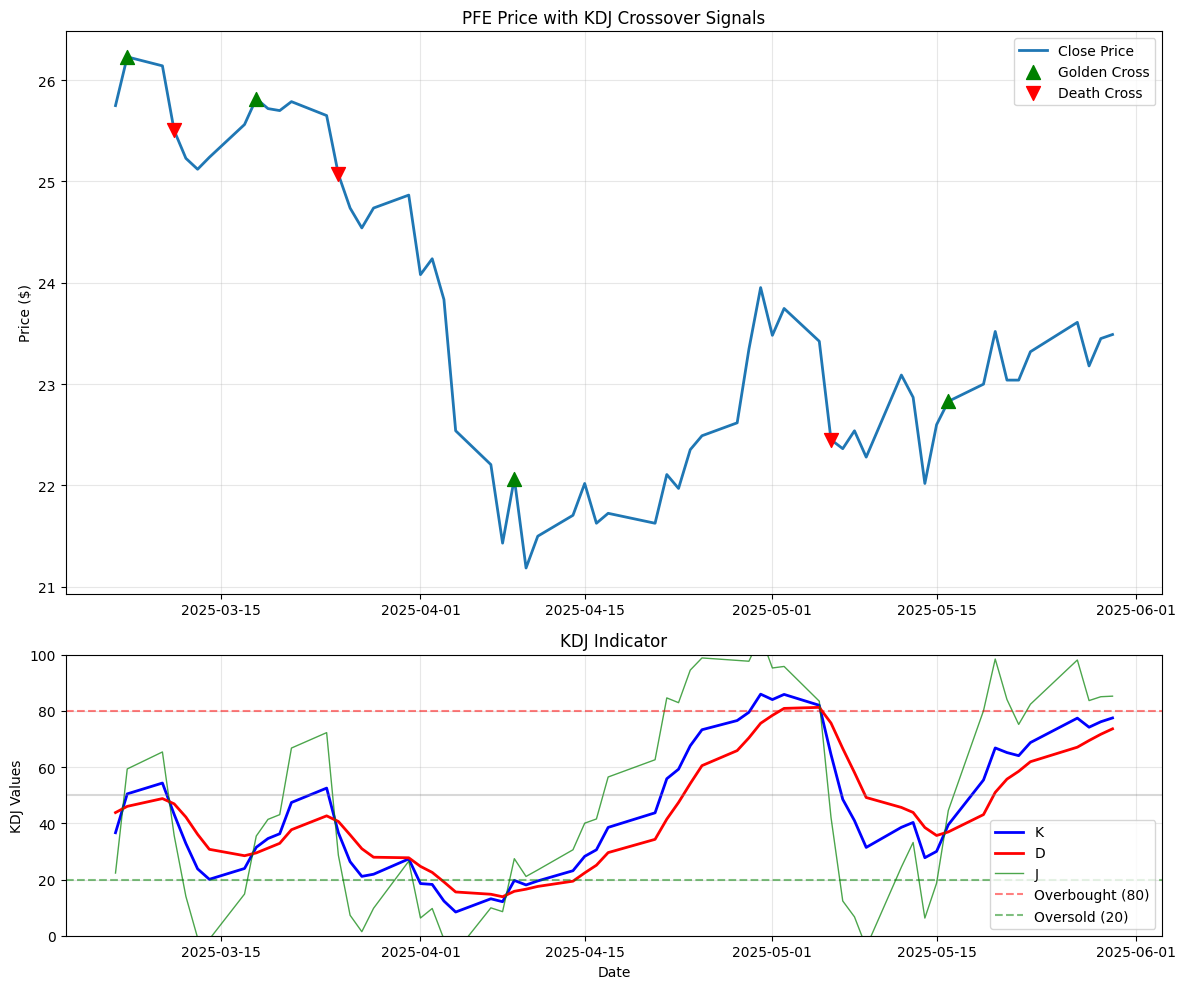

In [206]:
stock='PFE'
data =  downloader(stock, start_date,end_date)
detector = KDJCrossoverDetector(data)
signal=detector.run_analysis(verbose=True)

Processing data request for UTG.L from 2007-01-01 to 2025-05-31...
No cached data found for UTG.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for UTG.L. Shape: (4651, 5)
KDJ indicator calculated successfully
Processing data request for DOM.L from 2007-01-01 to 2025-05-31...
No cached data found for DOM.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DOM.L. Shape: (4651, 5)
KDJ indicator calculated successfully
Processing data request for GLEN.L from 2007-01-01 to 2025-05-31...
No cached data found for GLEN.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for GLEN.L. Shape: (3543, 5)
KDJ indicator calculated successfully
Processing data request for DGE.L from 2007-01-01 to 2025-05-31...
No cached data found for DGE.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for DGE.L. Shape: (4650, 5)
KDJ indicator calculated successfully
Processing data request for POLR.L from 2007-01-01 to 2025-05-31...
No cached data found for POLR.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for POLR.L. Shape: (4626, 5)
KDJ indicator calculated successfully
Crossover signals detected

⚠️  WARNING: KDJ values are converging!
   K-D difference: 0.42
   K-J difference: 0.84
   D-J difference: 1.26
   This may indicate an upcoming crossover or period of indecision.



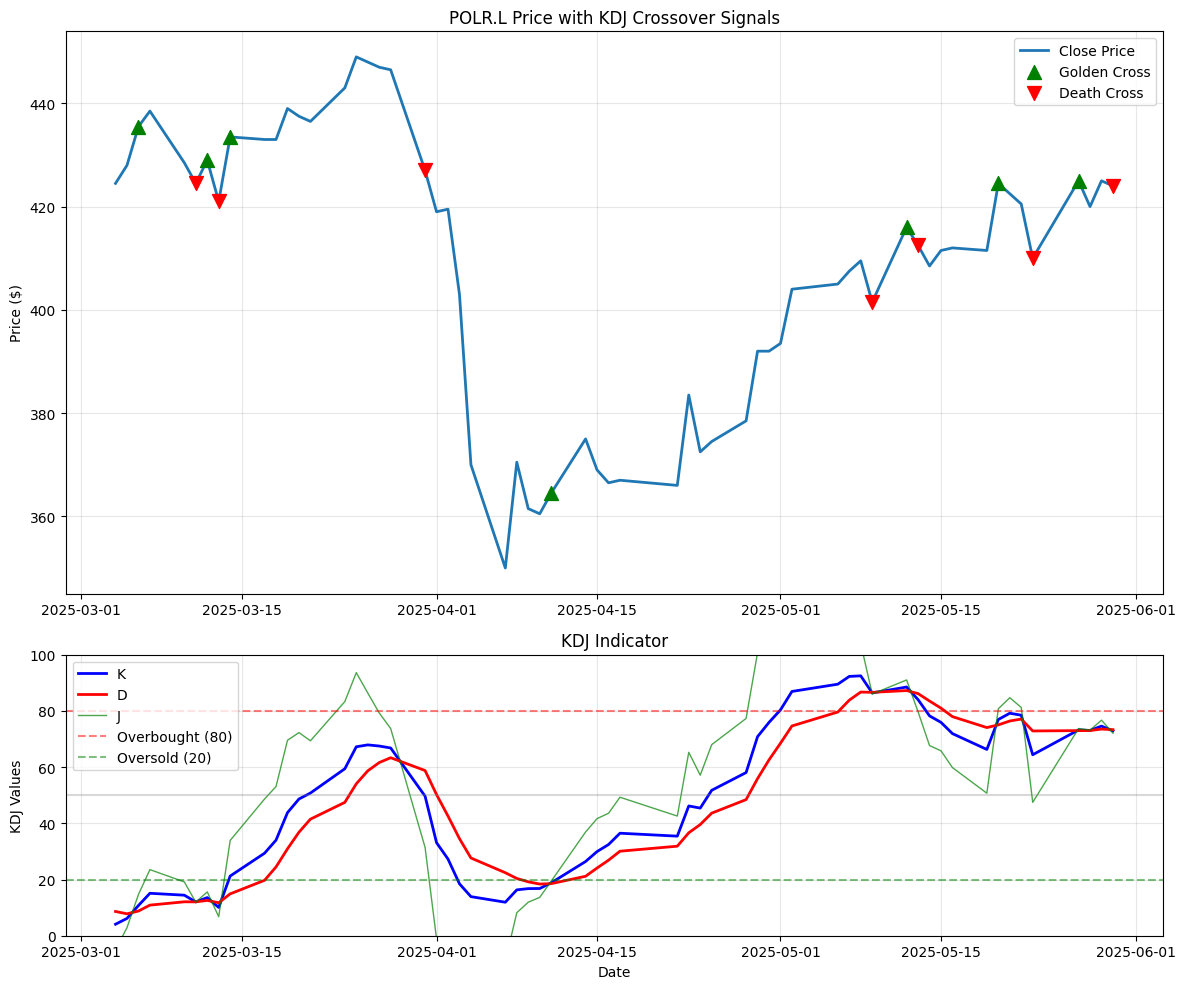

Processing data request for IPX.L from 2007-01-01 to 2025-05-31...
No cached data found for IPX.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for IPX.L. Shape: (4651, 5)
KDJ indicator calculated successfully
Processing data request for WPP.L from 2007-01-01 to 2025-05-31...
No cached data found for WPP.L - downloading all data...


[*********************100%***********************]  1 of 1 completed


Data download complete for WPP.L. Shape: (4650, 5)
KDJ indicator calculated successfully
Processing data request for SAFE.L from 2007-01-01 to 2025-05-31...
No cached data found for SAFE.L - downloading all data...


[*********************100%***********************]  1 of 1 completed

Data download complete for SAFE.L. Shape: (4603, 5)
KDJ indicator calculated successfully


In [216]:
signals=dict()
for stock in uk_symbols:
    
    data =  downloader(stock, start_date,end_date)
    detector = KDJCrossoverDetector(data)
    signal=detector.run_analysis()
    if signal is not None:
        signals[stock]=signal

In [217]:
signals

{'POLR.L': '\n⚠️  WARNING: KDJ values are converging!\n   K-D difference: 0.42\n   K-J difference: 0.84\n   D-J difference: 1.26\n   This may indicate an upcoming crossover or period of indecision.\n'}

In [164]:
data

,Close,High,Low,Open,Volume,GK_Volatility,YZ_Volatility
Date,,,,,,,
2007-01-03,9.634974,9.836217,9.550137,9.667529,17299200,NaN,NaN
2007-01-04,9.733624,9.763219,9.555071,9.634976,15085600,NaN,NaN
2007-01-05,9.749405,9.806621,9.637932,9.677391,14996800,NaN,NaN
2007-01-08,9.719813,9.765191,9.631030,9.716854,10109600,NaN,NaN
2007-01-09,9.841148,9.858905,9.703041,9.719811,15167200,NaN,NaN
...,...,...,...,...,...,...,...
2025-05-15,62.400002,62.680000,60.419998,60.639999,14371100,0.287548,0.432305
2025-05-16,63.110001,63.750000,62.500000,62.500000,12950600,0.281116,0.428843
2025-05-19,62.080002,62.430000,61.759998,62.150002,15105300,0.252806,0.411476


In [88]:
larger_proportion(res_dict['PFE']['YZ_Volatility'].dropna(),0.5)

0.03430308293530178

In [92]:
import seaborn as sns
def validate_volatility_estimators(data, window=20, trading_periods=252):
    """
    Comprehensive validation of volatility estimators with multiple metrics.
    
    Parameters:
    data: DataFrame containing 'GK_Volatility' and 'YZ_Volatility'
    window: Lookback window for realized volatility calculation
    trading_periods: Annualization factor (default 252)
    
    Returns:
    pd.Series with validation metrics
    """
    # Calculate realized volatility benchmark
    realized_vol = data['Close'].pct_change().rolling(window).std() * np.sqrt(trading_periods)
    #return realized_vol
    metrics = {
        # Error metrics
        'GK vs Realized MAE': (data['GK_Volatility'] - realized_vol).abs().mean(),
        'YZ vs Realized MAE': (data['YZ_Volatility'] - realized_vol).abs().mean(),
        'GK vs Realized RMSE': np.sqrt(((data['GK_Volatility'] - realized_vol)**2).mean()),
        'YZ vs Realized RMSE': np.sqrt(((data['YZ_Volatility'] - realized_vol)**2).mean()),
        
        # Correlation analysis
        'GK-YZ Correlation': data['GK_Volatility'].corr(data['YZ_Volatility']),
        'GK-Realized Corr': data['GK_Volatility'].corr(realized_vol),
        'YZ-Realized Corr': data['YZ_Volatility'].corr(realized_vol),
        
        # Volatility ratio analysis
        'Avg YZ/GK Ratio': data['YZ_Volatility'].mean() / data['GK_Volatility'].mean(),
        'Max YZ/GK Ratio': (data['YZ_Volatility'] / data['GK_Volatility']).max(),
        'Min YZ/GK Ratio': (data['YZ_Volatility'] / data['GK_Volatility']).min()
    }
    
    return pd.Series(metrics).round(4)

def plot_volatility_analysis(data, symbol):
    """
    Enhanced visualization with four complementary views
    """
    fig = plt.figure(figsize=(16, 18))
    gs = fig.add_gridspec(4, 2)
    
    # Price and Volatility Timeline
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(data['Close'], label='Price', color='#1f77b4')
    ax1.set_title(f'{symbol} Price Action', pad=20)
    ax1.set_ylabel('Price ($)', labelpad=15)
    ax1.grid(True, alpha=0.3)
    
    # Volatility Comparison
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(data['GK_Volatility'], label='Garman-Klass', color='#2ca02c')
    ax2.plot(data['YZ_Volatility'], label='Yang-Zhang', color='#d62728')
    ax2.set_title('Volatility Estimators Comparison', pad=20)
    ax2.set_ylabel('Annualized Volatility', labelpad=15)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Estimator Difference Analysis
    ax3 = fig.add_subplot(gs[2, 0])
    diff = data['YZ_Volatility'] - data['GK_Volatility']
    sns.histplot(diff.dropna(), kde=True, color='#9467bd', ax=ax3)
    ax3.set_title('Distribution of YZ-GK Volatility Difference')
    ax3.set_xlabel('Volatility Difference')
    ax3.grid(True, alpha=0.3)
    
    # Error Metrics Radar Chart
    ax4 = fig.add_subplot(gs[2, 1], polar=True)
    metrics = validate_volatility_estimators(data)
    error_metrics = metrics[['GK vs Realized MAE', 'YZ vs Realized MAE', 
                            'GK vs Realized RMSE', 'YZ vs Realized RMSE']]
    
    categories = error_metrics.index.str.replace(' vs Realized ', '\n')
    values = error_metrics.values
    values = np.concatenate((values, [values[0]]))
    
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax4.plot(angles, values, color='#ff7f0e', linewidth=2)
    ax4.fill(angles, values, color='#ff7f0e', alpha=0.25)
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(categories)
    ax4.set_title('Error Metrics Comparison', pad=30)
    
    # Correlation Matrix
    ax5 = fig.add_subplot(gs[3, :])
    corr_matrix = data[['GK_Volatility', 'YZ_Volatility']].join(
        realized_vol.rename('Realized_Vol')).corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax5,
                annot_kws={"size": 14}, cbar=False)
    ax5.set_title('Volatility Estimators Correlation Matrix', pad=20)
    
    plt.tight_layout()
    plt.show()


[*********************100%***********************]  1 of 1 completed

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

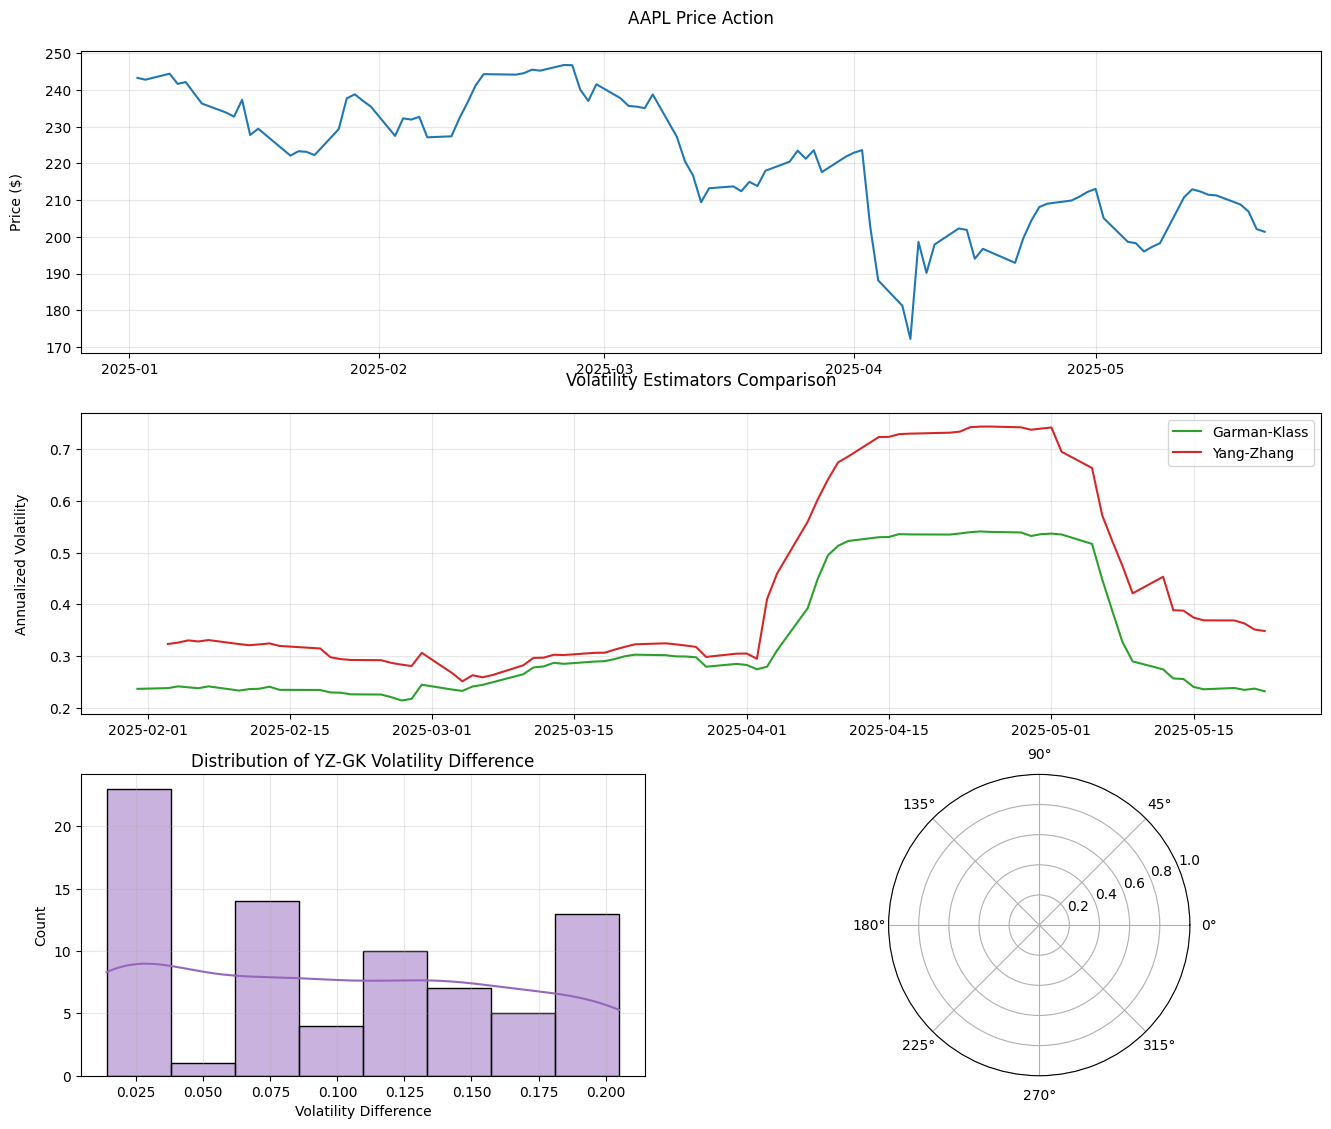

In [93]:
symbols = ['AAPL', 'GOOGL', 'MSFT', 'TSLA']
comparison_data = {}

for stock in symbols:
    # try:
    data = download_and_calculate_volatility(stock, start_date, end_date)

    plot_volatility_analysis(data,stock)
    # except Exception as e:
    #     print(f"Error processing {stock}: {e}")



li=[]
for i in range(1,2):
    file_path="data/active_options_stocks/"+str(i)+"_Most Active Stock Options - TipRanks.com.html"
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table', class_='screenerTable')

    # Extract headers
    headers = [th.get_text(strip=True) for th in table.thead.find_all('th')]

    # Extract rows
    rows = []
    for row in table.tbody.find_all('tr', class_='rt-tr'):
        cells = row.find_all('td', class_='rt-td')
        row_data = [cell.get_text(strip=True) for cell in cells]
        rows.append(row_data)

    # Create DataFrame
    df = pd.DataFrame(rows, columns=headers)
    li.append(df)
active_options_stocks=pd.concat(li)
active_options_stocks.set_index('Symbol',drop=True,inplace=True)